In [165]:
# ✅ 경로/파라미터 설정
IMAGES_DIR = r"C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\angle_velocity_data\tilt50\images_ud"  # 스캔 이미지 폴더 경로 (같은 폴더면 ".")
YOLO_MODEL_PATH = r"C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\dataset\runs\detect\train_y8m_ud2\weights\best.pt"  # YOLO 가중치(.pt)
CLASS_ID = None
CONF_TH  = 0.10      # YOLO confidence threshold
TILT_ABS_MAX = 100   # |tilt| ≤ 이 값인 샘플만 사용

# 파일명에서 pan/tilt 파싱 (예: img_t+00_p-010_*.jpg)
FNAME_REGEX = r"img_t(?P<tilt>[+-]?\d+(?:\.\d+)?)_p(?P<pan>[+-]?\d+(?:\.\d+)?)_.*\.(?:jpg|jpeg|png)$"

# ✅ YOLO 시각화 저장 옵션 (추가)
SAVE_ANNOTATED_IMG = True           # True면 YOLO 결과 그려 저장
OUT_VIS_DIR = "./yolo_vis"          # 저장 폴더

from pathlib import Path
Path(OUT_VIS_DIR).mkdir(parents=True, exist_ok=True)

print('IMAGES_DIR =', IMAGES_DIR)
print('YOLO_MODEL_PATH =', YOLO_MODEL_PATH)


IMAGES_DIR = C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\angle_velocity_data\tilt50\images_ud
YOLO_MODEL_PATH = C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\dataset\runs\detect\train_y8m_ud2\weights\best.pt


In [166]:
import re, json, csv
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt  # 그래프 표시(색 지정 X)

try:
    from ultralytics import YOLO
except Exception as e:
    raise RuntimeError("Ultralytics YOLO가 설치되어 있지 않습니다.\npip install ultralytics")


In [167]:
def find_images(root: Path):
    imgs = []
    for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"):
        imgs.extend(root.rglob(ext))
    return sorted(imgs)

def parse_angles(name: str, patt: re.Pattern):
    m = patt.search(name)
    if not m: 
        return None
    try:
        pan = float(m.group("pan")); tilt = float(m.group("tilt"))
        return pan, tilt
    except Exception:
        return None

def pick_box(result, W, H, class_id=None, conf_th=0.0):
    """
    필터 최소화: 클래스/CONF/중앙성 전부 무시하고
    감지된 것 중 conf 최고 하나만 반환.
    반환: (x1,y1,x2,y2,conf,cls) 또는 None
    """
    if result is None or result.boxes is None or len(result.boxes) == 0:
        return None
    best = None
    best_conf = -1.0
    for b in result.boxes:
        conf = float(b.conf.cpu().item()) if b.conf is not None else 0.0
        x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().tolist()
        cls = int(b.cls.cpu().item()) if b.cls is not None else -1
        if conf > best_conf:
            best_conf = conf
            best = (x1,y1,x2,y2,conf,cls)
    return best



def linearity_metrics(pan_deg, cx_px, W_frame):
    x = np.asarray(pan_deg, float)
    y = np.asarray(cx_px, float)
    if len(x) < 3 or np.std(x) < 0.5:  # 샘플 부족 또는 스윕 폭 부족
        return None
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]  # y ≈ a*x + b
    yhat = a*x + b
    resid = y - yhat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y - float(y.mean()))**2))
    R2 = 1.0 - ss_res/ss_tot if ss_tot>0 else 1.0
    max_abs_resid = float(np.max(np.abs(resid)))
    slopes = np.diff(y) / np.diff(x)
    slope_cov = float(np.std(slopes) / (np.mean(slopes)+1e-9))
    deg_per_px_x = 1.0 / a if abs(a) > 1e-9 else None
    pan_center = ((W_frame/2.0) - b) / a if abs(a) > 1e-9 else None
    return dict(a=float(a), b=float(b), R2=R2, max_resid_px=max_abs_resid,
                slope_cov=slope_cov, deg_per_px_x=deg_per_px_x, pan_center=pan_center)

def plot_scatter_pan_cx(x, y, a, b, out_png=None):
    plt.figure()
    plt.scatter(x, y, s=12, label="samples")
    xx = np.linspace(min(x), max(x), 200)
    yy = a*xx + b
    plt.plot(xx, yy, label=f"fit: y={a:.3f}x+{b:.2f}")
    plt.xlabel("pan (deg)")
    plt.ylabel("cx (px)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png)
    plt.show()

def save_annotated_image(img_bgr, res, out_png_path):
    """YOLO 박스 전부(녹색) 그려서 PNG로 저장"""
    vis = img_bgr.copy()
    if res is not None and res.boxes is not None and len(res.boxes) > 0:
        for b in res.boxes:
            conf = float(b.conf.cpu().item()) if b.conf is not None else 0.0
            x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
            cls = int(b.cls.cpu().item()) if b.cls is not None else -1
            p1, p2 = (int(x1), int(y1)), (int(x2), int(y2))
            cv2.rectangle(vis, p1, p2, (0,255,0), 2)
            cv2.putText(vis, f"{cls}:{conf:.2f}", (p1[0], max(15,p1[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
    ok, buf = cv2.imencode(".png", vis)
    if ok:
        buf.tofile(str(out_png_path))  # Windows 한글 경로 안전 저장


In [168]:
img_dir = Path(IMAGES_DIR)
assert img_dir.exists(), f"이미지 폴더가 존재하지 않습니다: {img_dir}"

# 폴더를 넣었을 경우 자동으로 best/last.pt 잡아주기(안전장치)
p = Path(YOLO_MODEL_PATH)
if p.is_dir():
    cand = list(p.glob("best*.pt")) + list(p.glob("last*.pt")) + list(p.glob("*.pt"))
    assert cand, f"'{p}' 폴더 안에 .pt 파일이 없습니다."
    YOLO_MODEL_PATH = str(cand[0])

model = YOLO(YOLO_MODEL_PATH)

patt = re.compile(FNAME_REGEX)
files = find_images(img_dir)
print(f"Found {len(files)} image files")
# print(files[:10])  # 필요시 확인


Found 242 image files


In [169]:
# YOLO 추론 → (pan, cx) 수집 (tilt≈0만) — CONF_TH 이상인 모든 박스 저장
rows = []
W_frame = None

# 선택: 특정 클래스만 쓸 거면 숫자, 전부 쓰려면 None
USE_CLASS_ID = None  # 예: 0  (혹은 None)

for fp in files:
    m = patt.search(fp.name)
    if not m:
        continue
    pan_deg = float(m.group("pan"))
    tilt_deg = float(m.group("tilt"))
    if abs(tilt_deg) > TILT_ABS_MAX:
        continue  # tilt≈0만 사용

    img = cv2.imdecode(np.fromfile(str(fp), dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        continue
    H, W = img.shape[:2]
    if W_frame is None:
        W_frame = W

    # ★ 여기서부터 conf=CONF_TH 를 그대로 사용
    res = model.predict(source=img, imgsz=max(W, H), conf=CONF_TH, verbose=False)[0]

    # (옵션) YOLO 결과 시각화 저장
    if SAVE_ANNOTATED_IMG and res is not None:
        out_png = Path(OUT_VIS_DIR) / f"{Path(fp).stem}.png"
        save_annotated_image(img, res, out_png)

    if res is None or res.boxes is None or len(res.boxes) == 0:
        continue

    # CONF_TH 이상, (옵션) 클래스 매칭되는 모든 박스 저장
    kept = 0
    for b in res.boxes:
        conf = float(b.conf.cpu().item()) if b.conf is not None else 0.0
        if conf < CONF_TH:
            continue
        cls = int(b.cls.cpu().item()) if b.cls is not None else -1
        if (USE_CLASS_ID is not None) and (cls != USE_CLASS_ID):
            continue

        x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
        cx = 0.5 * (x1 + x2)
        cy = 0.5 * (y1 + y2)

        rows.append({
            "file": fp.name,
            "pan_deg": pan_deg,
            "tilt_deg": tilt_deg,
            "cx": float(cx),
            "cy": float(cy),
            "w": float(x2 - x1),
            "h": float(y2 - y1),
            "conf": float(conf),
            "cls": int(cls),
            "W": int(W),
            "H": int(H),
        })
        kept += 1
    # print(f"{fp.name}: kept {kept}")  # 필요하면 켜서 확인

print(f"Collected detections (CONF_TH>={CONF_TH}): {len(rows)}")
assert len(rows) > 0, "유효한 감지 행이 없습니다. (CONF_TH / USE_CLASS_ID / TILT_ABS_MAX 확인)"


KeyboardInterrupt: 

In [ ]:
rows.sort(key=lambda r: r["pan_deg"])
x = [r["pan_deg"] for r in rows]
y = [r["cx"] for r in rows]

metrics = linearity_metrics(x, y, W_frame)
assert metrics is not None, "스윕 폭이 너무 작거나 샘플 수가 부족합니다."
metrics


C:\Users\gmlwn\AppData\Local\Temp\ipykernel_35140\4157909321.py:51: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(y) / np.diff(x)
C:\Users\gmlwn\AppData\Local\Temp\ipykernel_35140\4157909321.py:51: RuntimeWarning: invalid value encountered in divide
  slopes = np.diff(y) / np.diff(x)


{'a': -24.39261074339471,
 'b': 2033.2350306947308,
 'R2': 0.7785863876668693,
 'max_resid_px': 2312.3488706590742,
 'slope_cov': nan,
 'deg_per_px_x': -0.04099602172640707,
 'pan_center': 30.223703335829565}

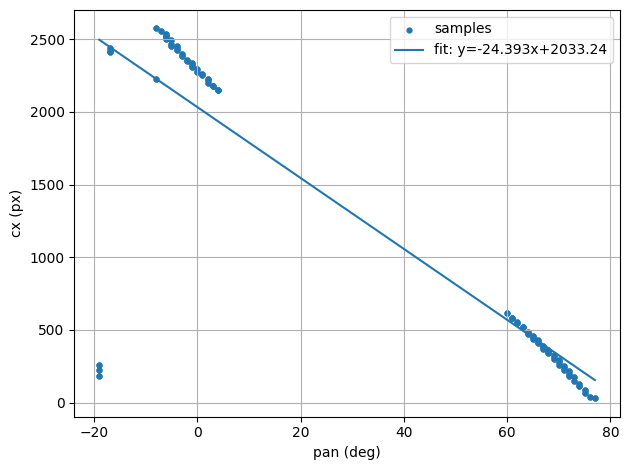

Saved CSV : pan_t0_samples.csv
Saved JSON: pan_t0_fit.json
Saved PLOT: pan_t0_plot.png


In [ ]:
out_prefix = "pan_t0"

# CSV
csv_path = f"{out_prefix}_samples.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    cols = ["file","pan_deg","tilt_deg","cx","cy","w","h","conf","cls","W","H"]
    w.writerow(cols)
    for r in rows:
        w.writerow([r.get(c,"") for c in cols])

# JSON
json_path = f"{out_prefix}_fit.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Plot
png_path = f"{out_prefix}_plot.png"
plot_scatter_pan_cx(x, y, metrics["a"], metrics["b"], png_path)

print("Saved CSV :", csv_path)
print("Saved JSON:", json_path)
print("Saved PLOT:", png_path)


['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '-5', '-10', '-15', '-20', '-25', '-30', '-35']
[INFO] total rows in CSV: 272
[INFO] kept rows (conf≥0.5): 212


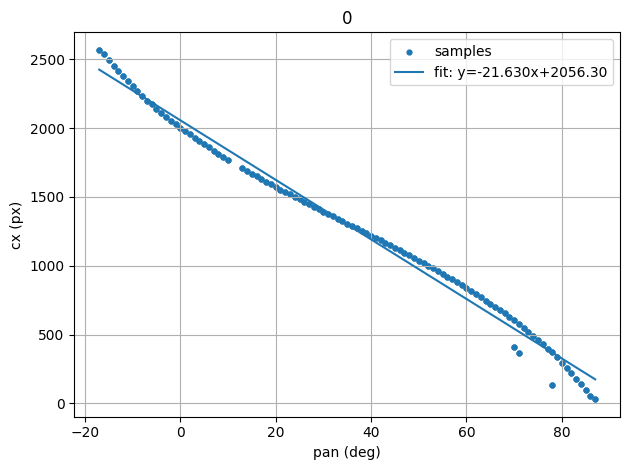

{'a_px_per_deg': -21.630207908763744, 'b_px': 2056.3034474533847}
[INFO] total rows in CSV: 286
[INFO] kept rows (conf≥0.5): 212


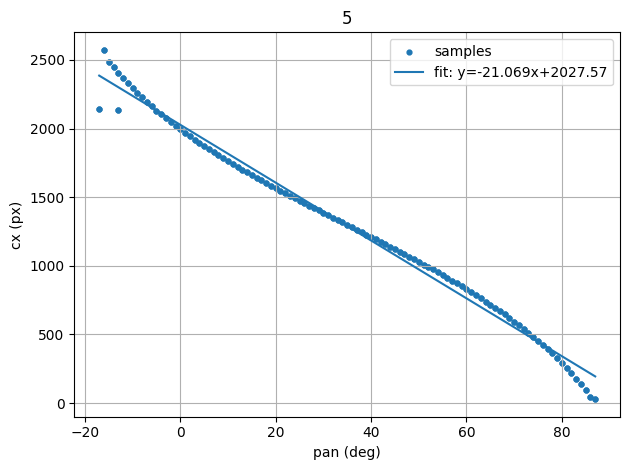

{'a_px_per_deg': -21.068759093202797, 'b_px': 2027.5736076431976}
[INFO] total rows in CSV: 294
[INFO] kept rows (conf≥0.5): 214


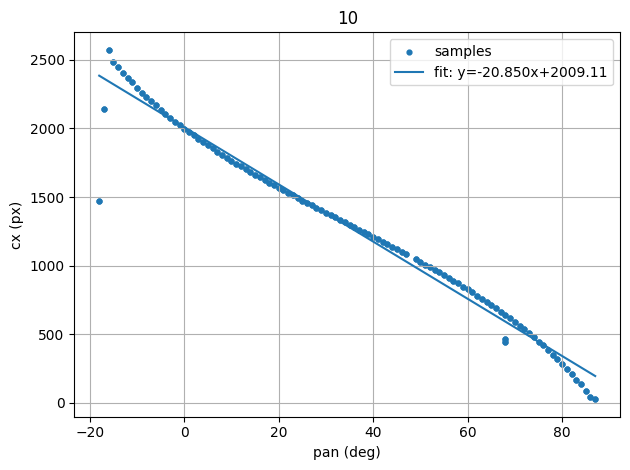

{'a_px_per_deg': -20.850146667904436, 'b_px': 2009.1051259861254}
[INFO] total rows in CSV: 266
[INFO] kept rows (conf≥0.5): 206


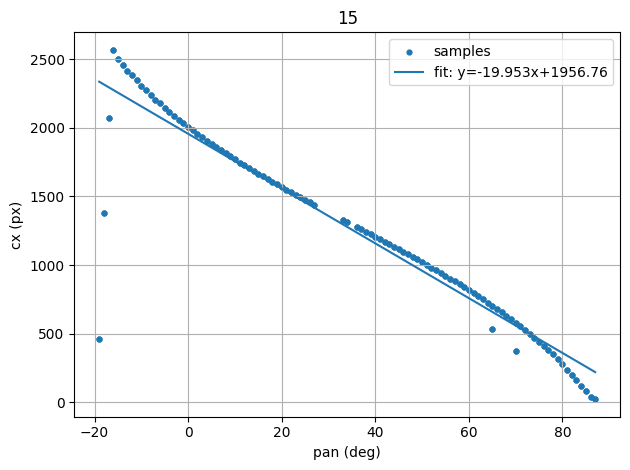

{'a_px_per_deg': -19.95292520628127, 'b_px': 1956.7551027126913}
[INFO] total rows in CSV: 276
[INFO] kept rows (conf≥0.5): 218


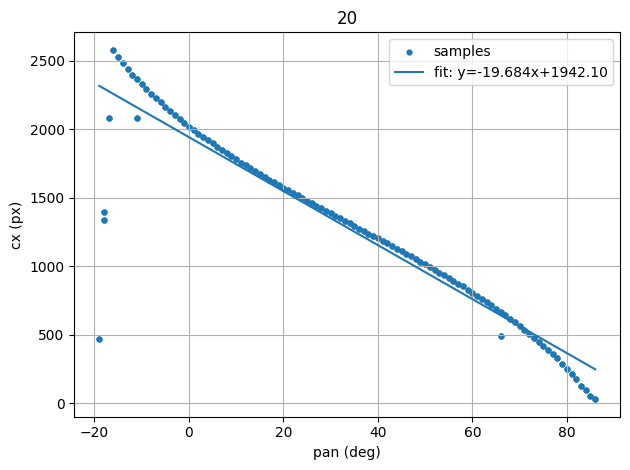

{'a_px_per_deg': -19.683707215005178, 'b_px': 1942.101676208885}
[INFO] total rows in CSV: 286
[INFO] kept rows (conf≥0.5): 220


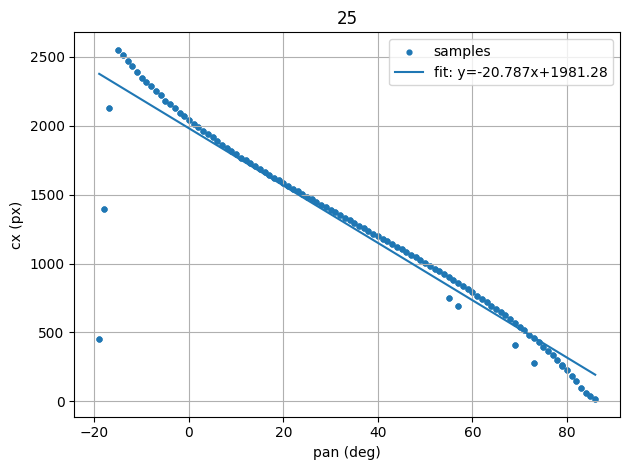

{'a_px_per_deg': -20.78702907228783, 'b_px': 1981.2822203667627}
[INFO] total rows in CSV: 278
[INFO] kept rows (conf≥0.5): 208


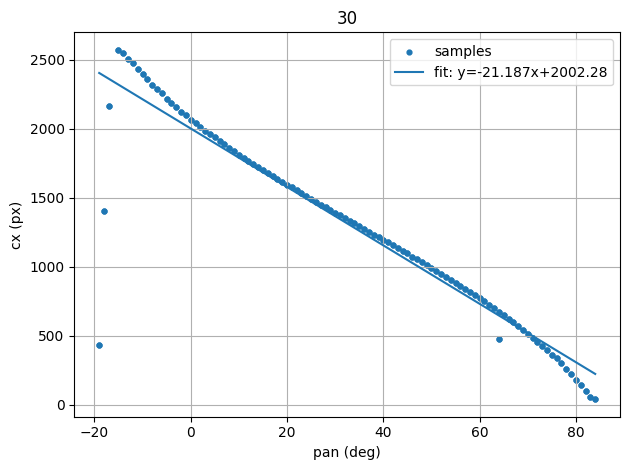

{'a_px_per_deg': -21.18708626400417, 'b_px': 2002.284378250021}
[INFO] total rows in CSV: 300
[INFO] kept rows (conf≥0.5): 212


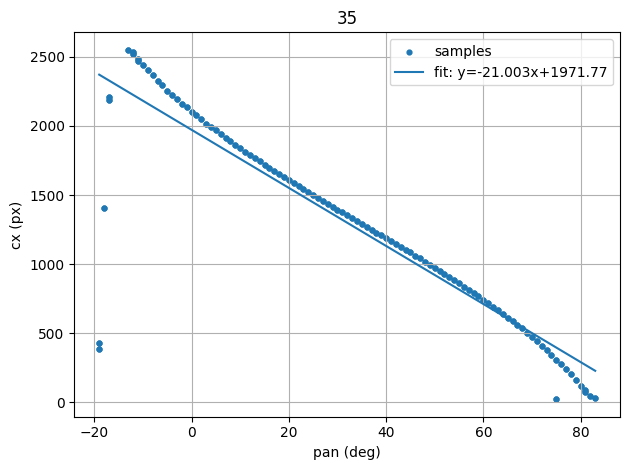

{'a_px_per_deg': -21.002627021332405, 'b_px': 1971.766021181214}
[INFO] total rows in CSV: 290
[INFO] kept rows (conf≥0.5): 220


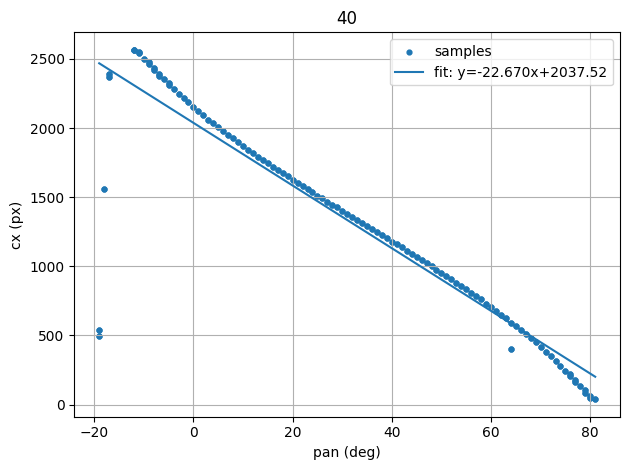

{'a_px_per_deg': -22.670285300487258, 'b_px': 2037.5176996797254}
[INFO] total rows in CSV: 340
[INFO] kept rows (conf≥0.5): 204


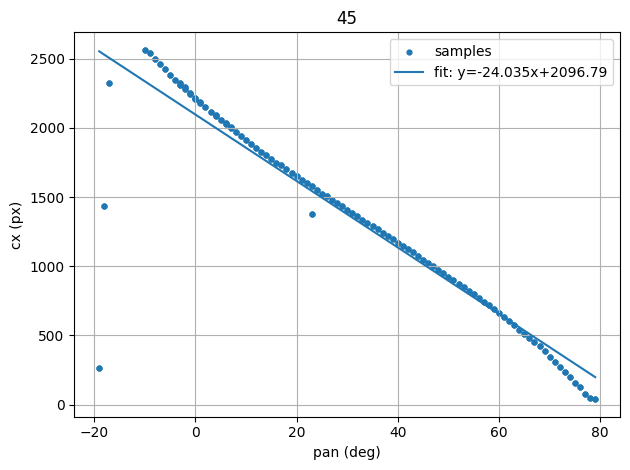

{'a_px_per_deg': -24.035194134050446, 'b_px': 2096.78795191081}
[INFO] total rows in CSV: 158
[INFO] kept rows (conf≥0.5): 82


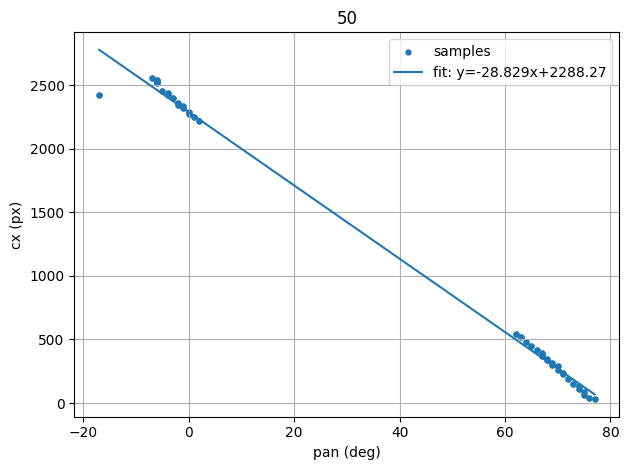

{'a_px_per_deg': -28.82946833270294, 'b_px': 2288.2718138189757}
[INFO] total rows in CSV: 350
[INFO] kept rows (conf≥0.5): 250


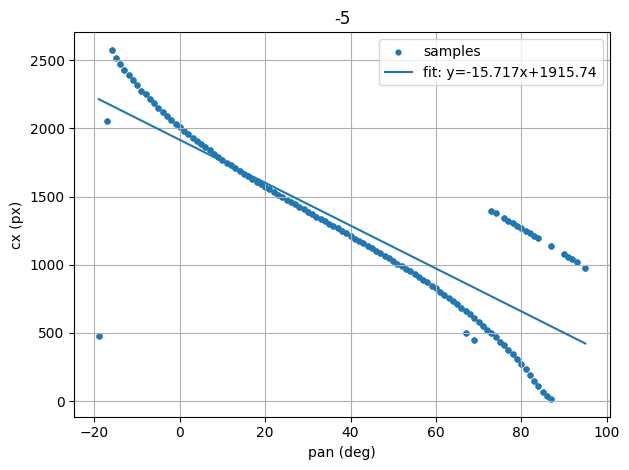

{'a_px_per_deg': -15.717476967888448, 'b_px': 1915.7405544671833}
[INFO] total rows in CSV: 390
[INFO] kept rows (conf≥0.5): 220


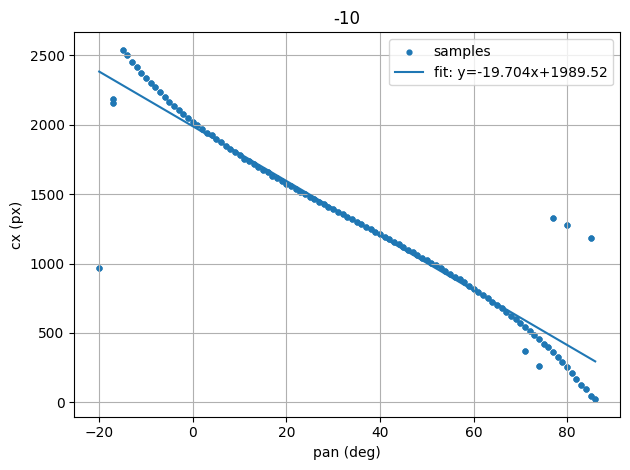

{'a_px_per_deg': -19.70375535621731, 'b_px': 1989.521661417608}
[INFO] total rows in CSV: 278
[INFO] kept rows (conf≥0.5): 224


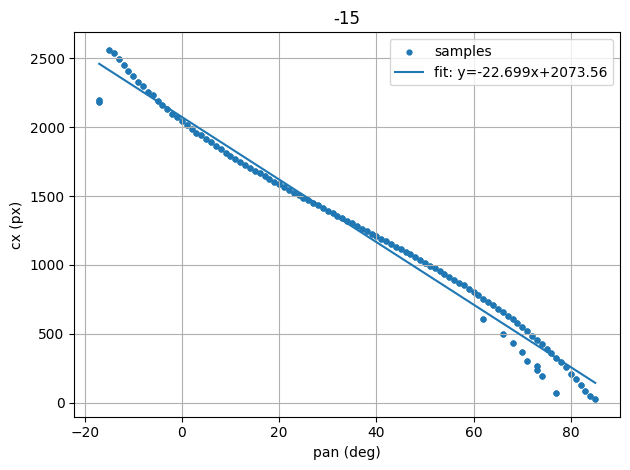

{'a_px_per_deg': -22.699154217432515, 'b_px': 2073.5634305111716}
[INFO] total rows in CSV: 272
[INFO] kept rows (conf≥0.5): 204


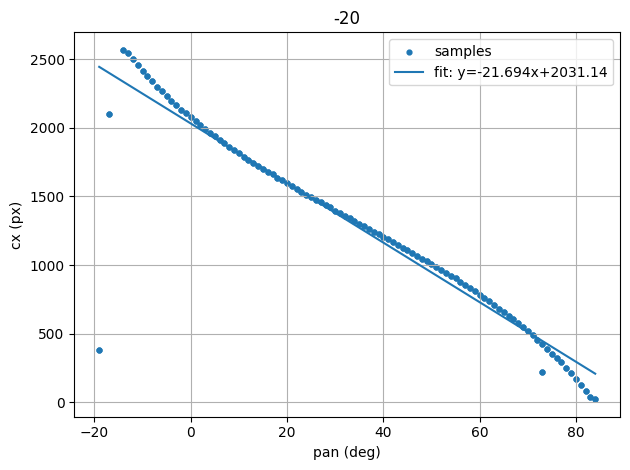

{'a_px_per_deg': -21.6941130398921, 'b_px': 2031.143822882806}
[INFO] total rows in CSV: 300
[INFO] kept rows (conf≥0.5): 204


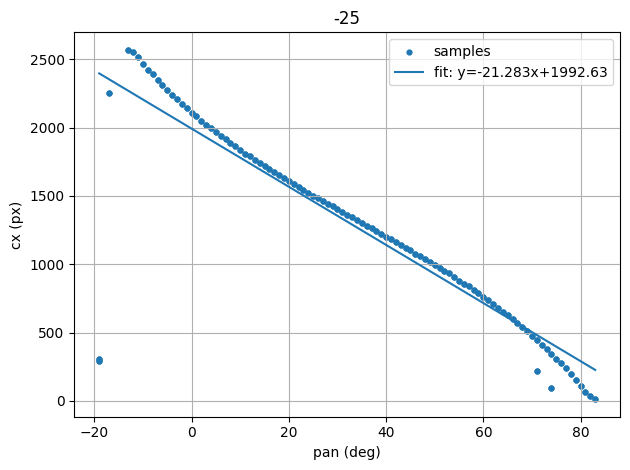

{'a_px_per_deg': -21.283318324444163, 'b_px': 1992.6251832164749}
[INFO] total rows in CSV: 282
[INFO] kept rows (conf≥0.5): 194


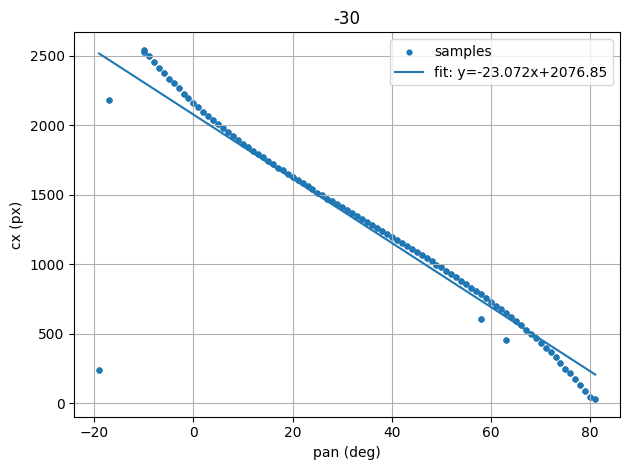

{'a_px_per_deg': -23.071642593987264, 'b_px': 2076.851135196668}
[INFO] total rows in CSV: 298
[INFO] kept rows (conf≥0.5): 194


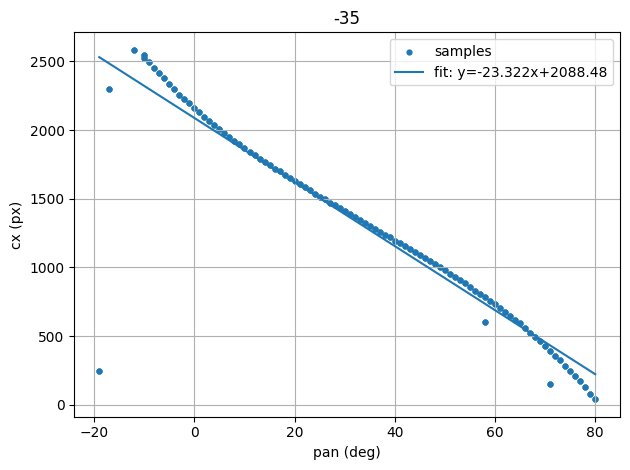

{'a_px_per_deg': -23.32196508264996, 'b_px': 2088.483877666626}


In [ ]:
#0 CSV → conf 필터 → 산점도 + 선형 피팅
import csv, numpy as np, matplotlib.pyplot as plt
tiltlist = [str(i*5) for i in range(0,11)]
_list = ['-'+str(i*5) for i in range(1,8)]
tiltlist += _list

print(tiltlist)
for i in range(len(tiltlist)):
        
    CSV_PATH   = r"yolo_vis_{}/pan_t0_samples.csv".format(tiltlist[i])  # 네 CSV 파일명으로 변경
    CONF_MIN   = 0.5                  # 이 값 이상만 플롯
    USE_CLASS  = None                  # 특정 클래스만 보려면 숫자, 전체면 None
    PAN_RANGE  = None                  # 예: (-10, 30) 범위만 쓰려면 (min,max), 전체면 None

    xs, ys, W_frame = [], [], None
    total_rows = kept_rows = 0

    with open(CSV_PATH, newline="", encoding="utf-8") as f:
        r = csv.DictReader(f)
        for row in r:
            total_rows += 1
            conf = float(row["conf"])
            cls  = int(row["cls"]) if row["cls"] != "" else -1
            pan  = float(row["pan_deg"])
            if conf < CONF_MIN: 
                continue
            if (USE_CLASS is not None) and (cls != USE_CLASS):
                continue
            if PAN_RANGE is not None:
                if not (PAN_RANGE[0] <= pan <= PAN_RANGE[1]):
                    continue

            xs.append(pan)
            ys.append(float(row["cx"]))
            if W_frame is None and row.get("W"):
                try:
                    W_frame = int(row["W"])
                except:
                    W_frame = None
            kept_rows += 1

    print(f"[INFO] total rows in CSV: {total_rows}")
    print(f"[INFO] kept rows (conf≥{CONF_MIN}"
        f"{'' if USE_CLASS is None else f', class={USE_CLASS}'}"
        f"{'' if PAN_RANGE is None else f', pan∈{PAN_RANGE}'}): {kept_rows}")

    if kept_rows >= 3:
        A = np.vstack([xs, np.ones_like(xs)]).T
        a, b = np.linalg.lstsq(A, ys, rcond=None)[0]

        plt.figure(i)
        plt.scatter(xs, ys, s=12, label="samples")
        xx = np.linspace(min(xs), max(xs), 200)
        yy = a*xx + b
        plt.title(f"{tiltlist[i]}")
        plt.plot(xx, yy, label=f"fit: y={a:.3f}x+{b:.2f}")
        plt.xlabel("pan (deg)")
        plt.ylabel("cx (px)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print({"a_px_per_deg": float(a), "b_px": float(b)})
    else:
        print("⚠️ 필터 후 샘플이 부족합니다. CONF_MIN/USE_CLASS/PAN_RANGE를 조정하세요.")


['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '-5', '-10', '-15', '-20', '-25', '-30', '-35']
[0] total=272, kept=212


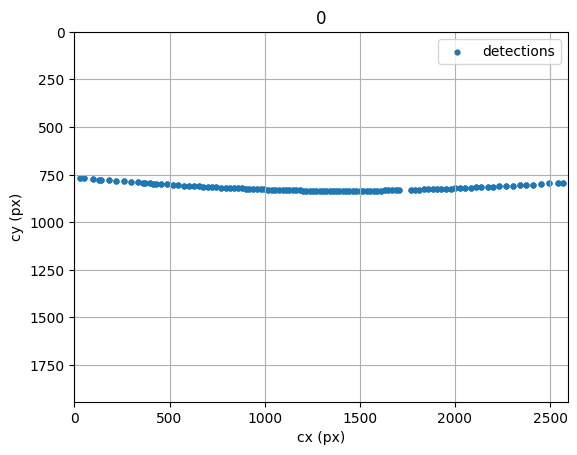

[5] total=286, kept=212


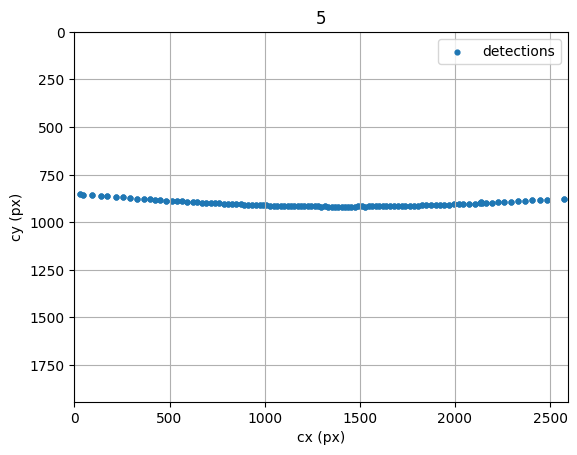

[10] total=294, kept=214


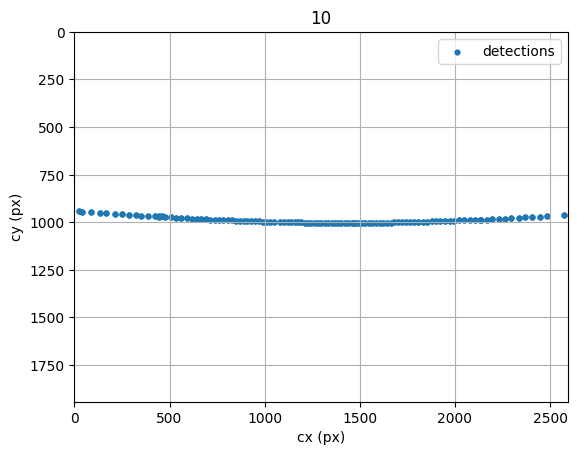

[15] total=266, kept=206


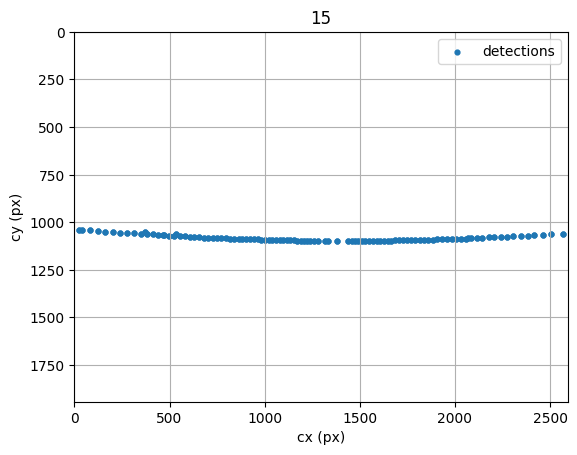

[20] total=276, kept=218


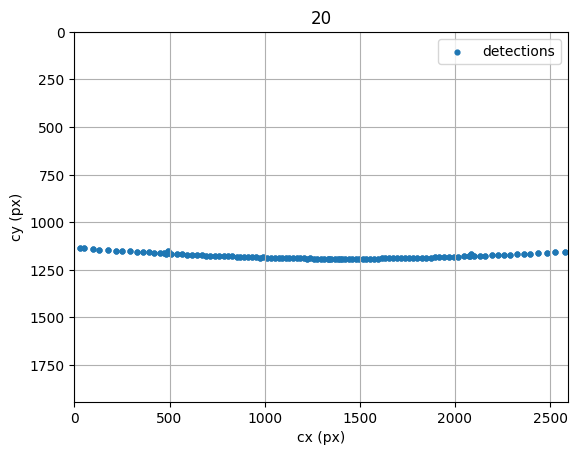

[25] total=286, kept=220


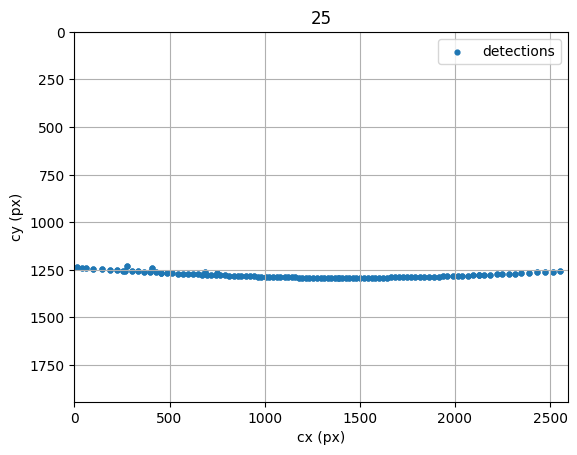

[30] total=278, kept=208


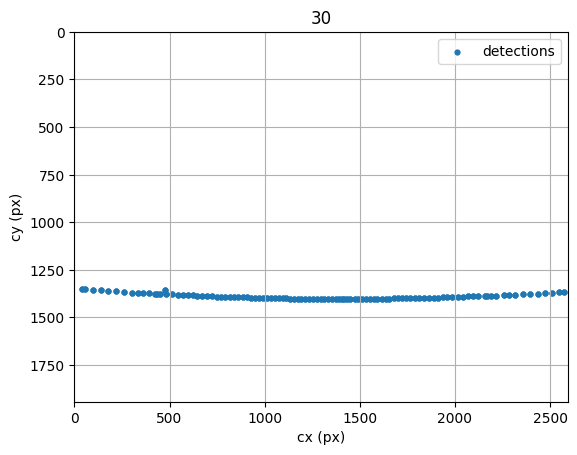

[35] total=300, kept=212


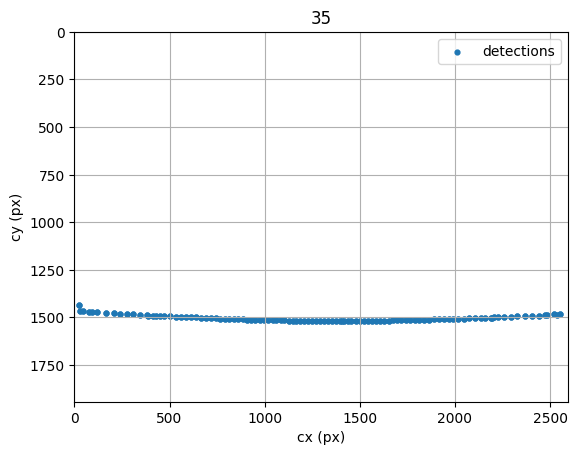

[40] total=290, kept=220


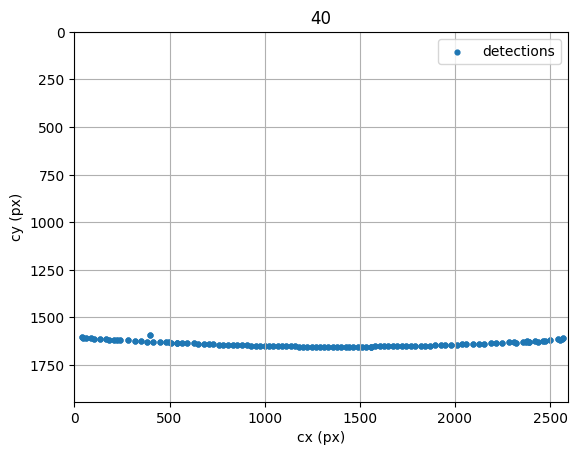

[45] total=340, kept=204


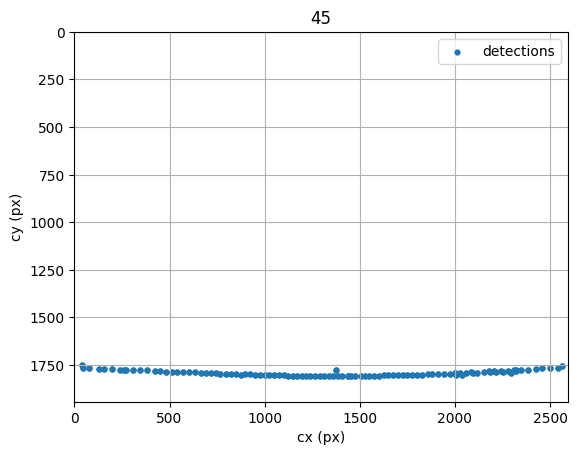

[50] total=158, kept=82


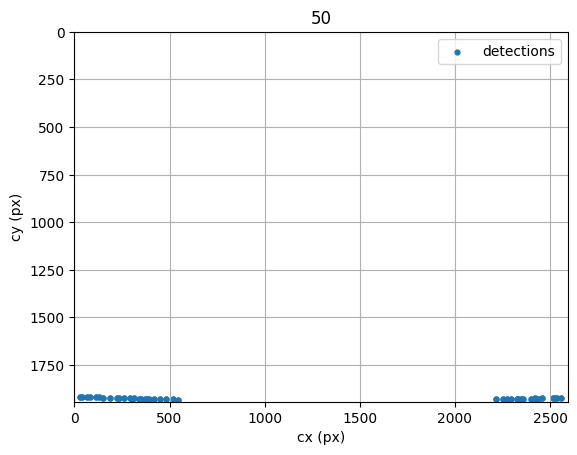

[-5] total=350, kept=250


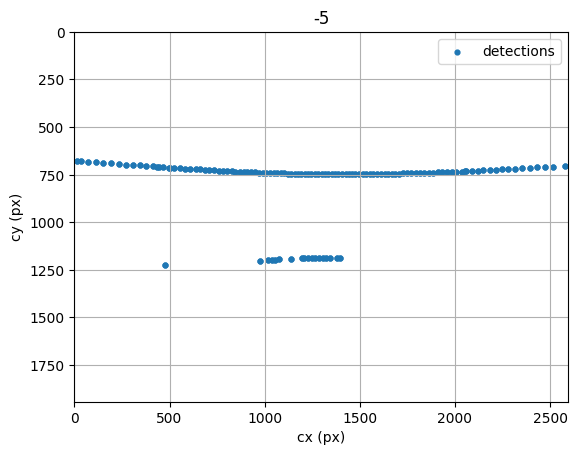

[-10] total=390, kept=220


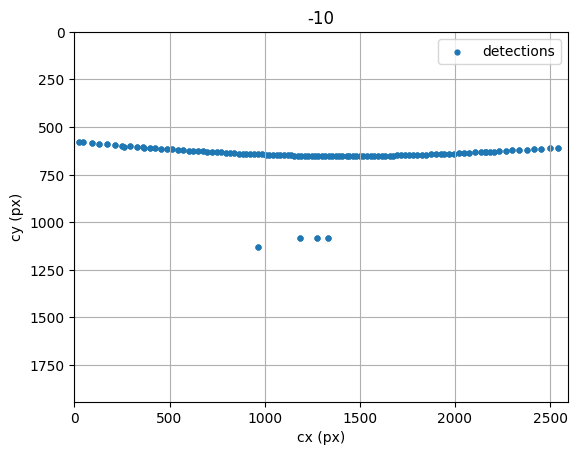

[-15] total=278, kept=224


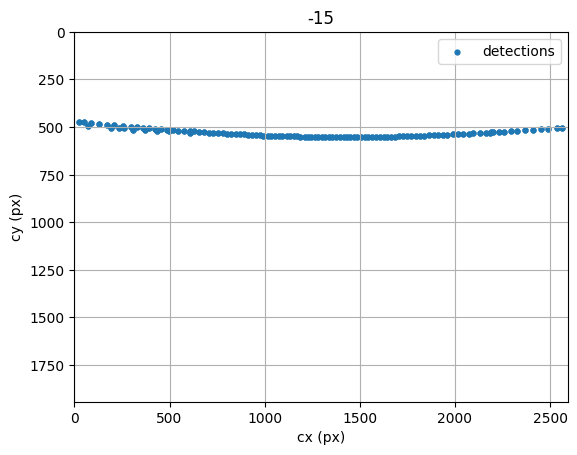

[-20] total=272, kept=204


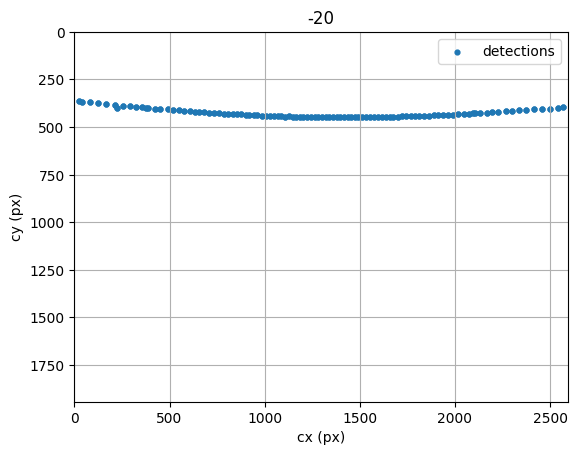

[-25] total=300, kept=204


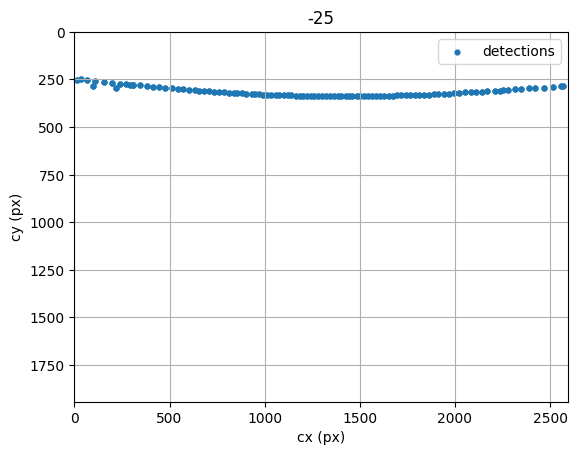

[-30] total=282, kept=194


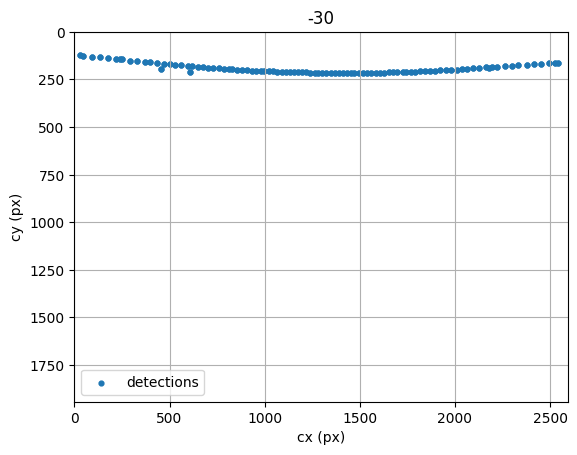

[-35] total=298, kept=194


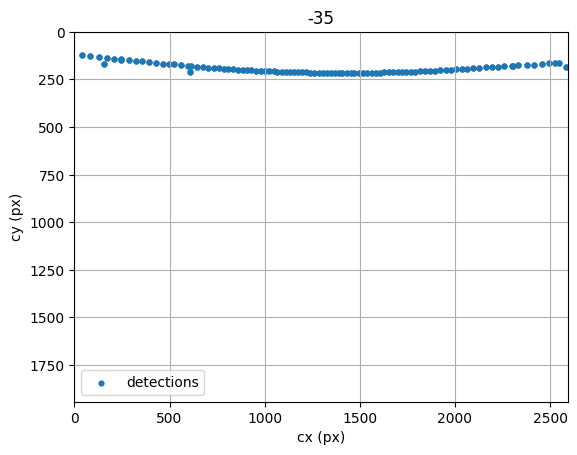

In [175]:
# CSV → conf 필터 → cx-cy 산점도 (+ pan 순서 경로 라인)
import csv, numpy as np, matplotlib.pyplot as plt

tiltlist = [str(i*5) for i in range(0,11)]
tiltlist += ['-'+str(i*5) for i in range(1,8)]
print(tiltlist)

CONF_MIN  = 0.50       # 이 값 이상만 사용
USE_CLASS = None       # 특정 클래스만 보려면 숫자, 전체면 None
PAN_RANGE = None       # 예: (-10, 60) 범위만 쓰고 싶으면 지정, 아니면 None

for i, tilt in enumerate(tiltlist):
    CSV_PATH = rf"yolo_vis_{tilt}\pan_t0_samples.csv"

    pans, cxs, cys = [], [], []
    W_frame = H_frame = None
    total_rows = kept_rows = 0

    with open(CSV_PATH, newline="", encoding="utf-8") as f:
        r = csv.DictReader(f)
        for row in r:
            total_rows += 1
            conf = float(row["conf"])
            if conf < CONF_MIN:
                continue
            cls = int(row["cls"]) if row["cls"] != "" else -1
            if (USE_CLASS is not None) and (cls != USE_CLASS):
                continue
            pan = float(row["pan_deg"])
            if PAN_RANGE is not None:
                if not (PAN_RANGE[0] <= pan <= PAN_RANGE[1]):
                    continue

            cxs.append(float(row["cx"]))
            cys.append(float(row["cy"]))
            pans.append(pan)
            if W_frame is None and row.get("W"): W_frame = int(row["W"])
            if H_frame is None and row.get("H"): H_frame = int(row["H"])
            kept_rows += 1

    print(f"[{tilt}] total={total_rows}, kept={kept_rows}")
    if kept_rows < 3:
        print("  ⚠️ 샘플 부족")
        continue

    # pan 기준으로 정렬해서 '경로' 라인을 매끈하게 연결
    order = np.argsort(np.array(pans))
    cx_sorted = np.array(cxs)[order]
    cy_sorted = np.array(cys)[order]

    plt.figure(i, figsize=(6,4.6))
    # 산점도 (cx, cy)
    plt.scatter(cxs, cys, s=12, label="detections")
    # 경로 라인 (pan 오름차순 연결)
    #plt.plot(cx_sorted, cy_sorted, linewidth=1, label="path (by pan)")

    plt.title(tilt)
    plt.xlabel("cx (px)")
    plt.ylabel("cy (px)")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')   # 픽셀 비율 유지
    ax.invert_yaxis()                          # 영상 좌표(y 아래로 +)
    if W_frame and H_frame:
        plt.xlim(0, W_frame)
        plt.ylim(H_frame, 0)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


tilts: ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '-5', '-10', '-15', '-20', '-25', '-30', '-35']


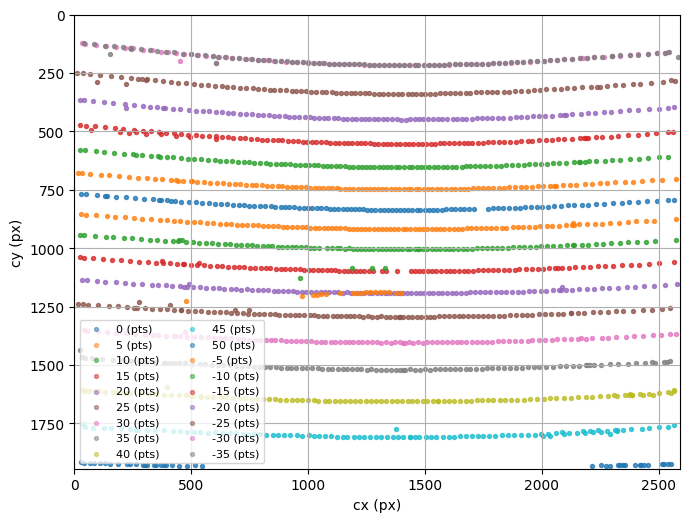

In [176]:
# 모든 tilt CSV를 한 그림에 cx–cy로 겹쳐서 표시 (conf 필터/선택적 pan 범위)
import csv, numpy as np, matplotlib.pyplot as plt

tiltlist = [str(i*5) for i in range(0,11)]
tiltlist += ['-'+str(i*5) for i in range(1,8)]
print("tilts:", tiltlist)

CONF_MIN  = 0.50         # 이 값 이상만 사용
USE_CLASS = None         # 특정 클래스만 보려면 숫자, 전체면 None
PAN_RANGE = None         # 예: (-10, 60) 범위만, 전체면 None

W_frame = H_frame = None
plt.figure(figsize=(7, 6))

for tilt in tiltlist:
    CSV_PATH = rf"yolo_vis_{tilt}\pan_t0_samples.csv"

    pans, cxs, cys = [], [], []
    total_rows = kept_rows = 0

    try:
        with open(CSV_PATH, newline="", encoding="utf-8") as f:
            r = csv.DictReader(f)
            for row in r:
                total_rows += 1
                conf = float(row["conf"])
                if conf < CONF_MIN:
                    continue
                cls = int(row["cls"]) if row["cls"] != "" else -1
                if (USE_CLASS is not None) and (cls != USE_CLASS):
                    continue
                pan = float(row["pan_deg"])
                if PAN_RANGE is not None and not (PAN_RANGE[0] <= pan <= PAN_RANGE[1]):
                    continue

                cxs.append(float(row["cx"]))
                cys.append(float(row["cy"]))
                pans.append(pan)
                if W_frame is None and row.get("W"): W_frame = int(row["W"])
                if H_frame is None and row.get("H"): H_frame = int(row["H"])
                kept_rows += 1
    except FileNotFoundError:
        print(f"[skip] {CSV_PATH} 없음")
        continue

    if kept_rows < 3:
        print(f"[{tilt}] total={total_rows}, kept={kept_rows} → 샘플 부족")
        continue

    # pan 오름차순으로 정렬해서 경로 연결
    order = np.argsort(np.array(pans))
    cx_sorted = np.array(cxs)[order]
    cy_sorted = np.array(cys)[order]

    # 같은 플롯에 점+라인 추가
    plt.scatter(cxs, cys, s=8, alpha=0.5, label=f"{tilt} (pts)")
    #plt.plot(cx_sorted, cy_sorted, linewidth=1, alpha=0.9, label=f"{tilt} (path)")

# 축/레이아웃
plt.xlabel("cx (px)")
plt.ylabel("cy (px)")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')   # 픽셀 비율 유지
ax.invert_yaxis()                          # 영상 좌표(y 아래로 +)
if W_frame and H_frame:
    plt.xlim(0, W_frame)
    plt.ylim(H_frame, 0)
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


[INFO] gathered rows near pan=-20±0.6° : 2
[INFO] gathered rows near pan=-10±0.6° : 40
[INFO] dedup per tilt → 17 points
{'pan≈': '-10±0.6 deg', 'e_px_per_deg': 19.88425598144532, 'f_px': 801.9687778248506, 'R2': 0.9966172994105974, 'max_resid_px': 61.420489142922634, 'N': 17}


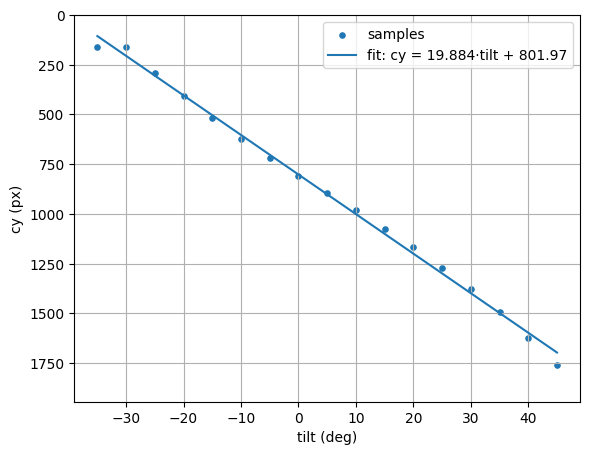

[INFO] gathered rows near pan=0±0.6° : 57
[INFO] dedup per tilt → 18 points
{'pan≈': '0±0.6 deg', 'e_px_per_deg': 20.209561494211176, 'f_px': 822.0836690424397, 'R2': 0.9940525173730169, 'max_resid_px': 98.02541445012639, 'N': 18}


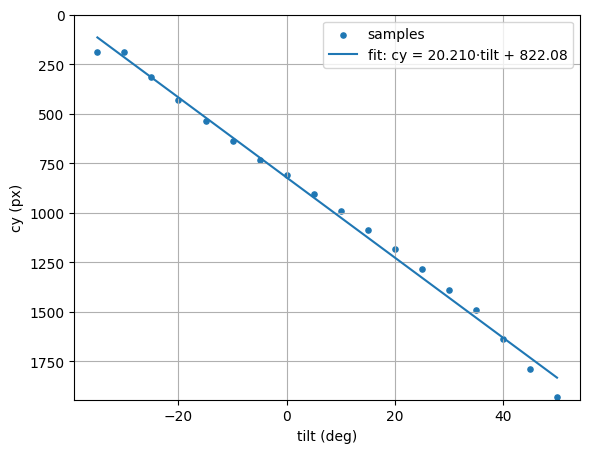

[INFO] gathered rows near pan=10±0.6° : 52
[INFO] dedup per tilt → 18 points
{'pan≈': '10±0.6 deg', 'e_px_per_deg': 20.1361635347884, 'f_px': 826.8728868178089, 'R2': 0.993698106706967, 'max_resid_px': 96.90609464589625, 'N': 18}


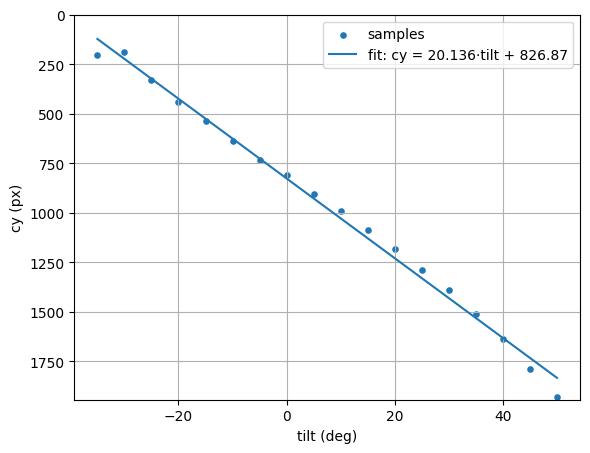

[INFO] gathered rows near pan=20±0.6° : 52
[INFO] dedup per tilt → 18 points
{'pan≈': '20±0.6 deg', 'e_px_per_deg': 20.162490473098682, 'f_px': 831.6305773314801, 'R2': 0.9941020445558092, 'max_resid_px': 90.83205721671084, 'N': 18}


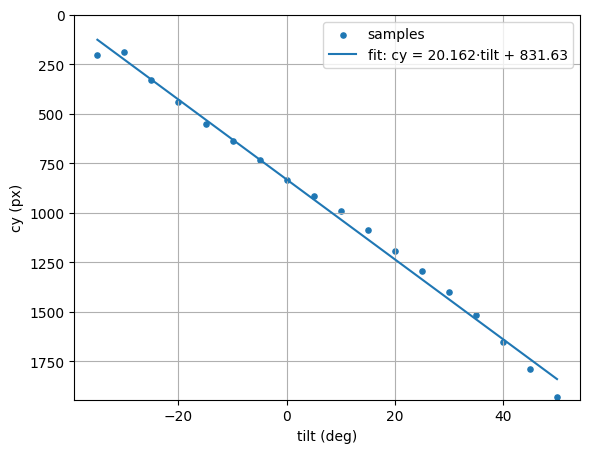

[INFO] gathered rows near pan=30±0.6° : 50
[INFO] dedup per tilt → 18 points
{'pan≈': '30±0.6 deg', 'e_px_per_deg': 20.14827366879112, 'f_px': 833.0467762194183, 'R2': 0.993790264083724, 'max_resid_px': 90.12669854415071, 'N': 18}


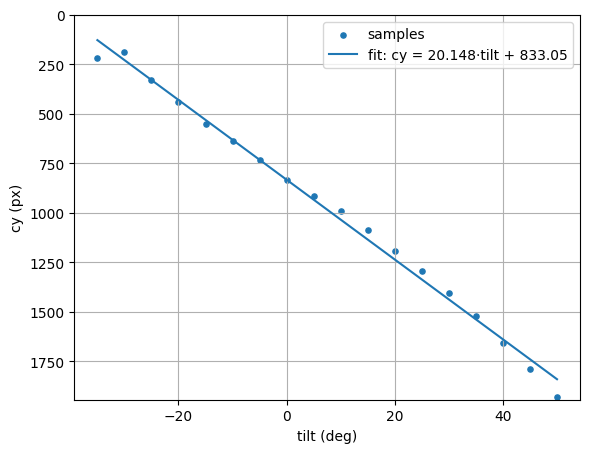

[INFO] gathered rows near pan=40±0.6° : 52
[INFO] dedup per tilt → 18 points
{'pan≈': '40±0.6 deg', 'e_px_per_deg': 20.120357359895028, 'f_px': 835.044932987094, 'R2': 0.9938046452445528, 'max_resid_px': 89.52435722127962, 'N': 18}


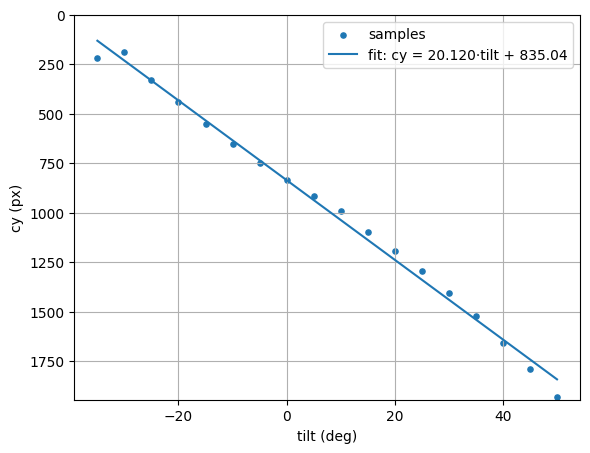

[INFO] gathered rows near pan=50±0.6° : 52
[INFO] dedup per tilt → 18 points
{'pan≈': '50±0.6 deg', 'e_px_per_deg': 20.106233157068342, 'f_px': 834.8052495451863, 'R2': 0.9937402528420365, 'max_resid_px': 90.47025080452158, 'N': 18}


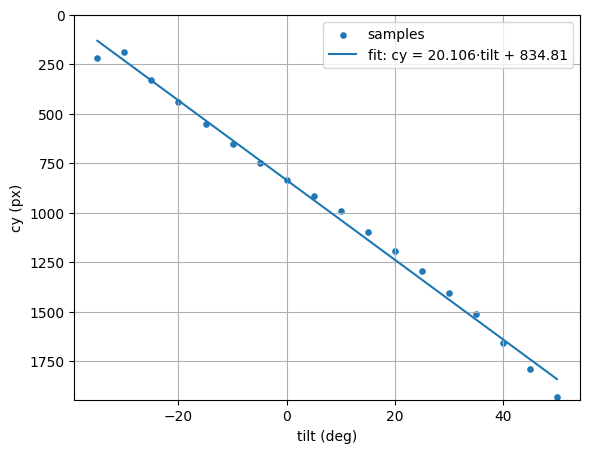

[INFO] gathered rows near pan=60±0.6° : 52
[INFO] dedup per tilt → 18 points
{'pan≈': '60±0.6 deg', 'e_px_per_deg': 20.08902099105473, 'f_px': 834.5131643037432, 'R2': 0.9936429156982944, 'max_resid_px': 91.62294434664523, 'N': 18}


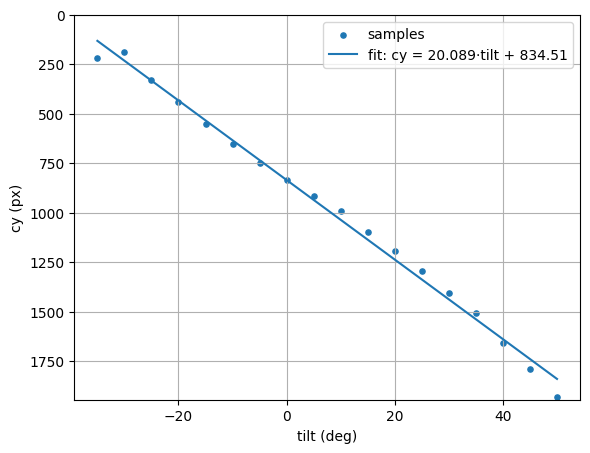

[INFO] gathered rows near pan=70±0.6° : 62
[INFO] dedup per tilt → 18 points
{'pan≈': '70±0.6 deg', 'e_px_per_deg': 20.13379699895995, 'f_px': 825.8966672967546, 'R2': 0.99276906439827, 'max_resid_px': 95.63350244711717, 'N': 18}


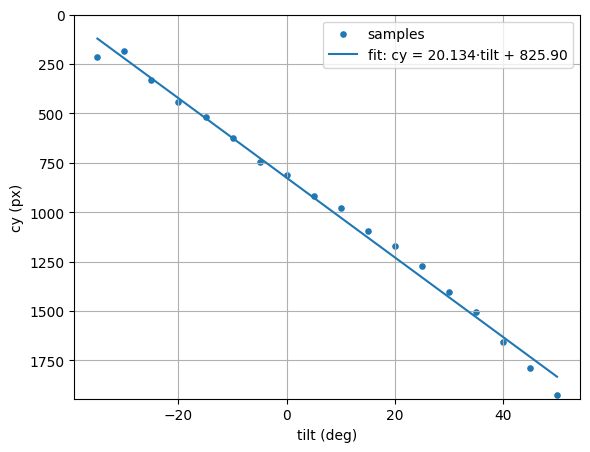

[INFO] gathered rows near pan=80±0.6° : 56
[INFO] dedup per tilt → 18 points
{'pan≈': '80±0.6 deg', 'e_px_per_deg': 20.13379699895995, 'f_px': 825.8966672967546, 'R2': 0.99276906439827, 'max_resid_px': 95.63350244711717, 'N': 18}


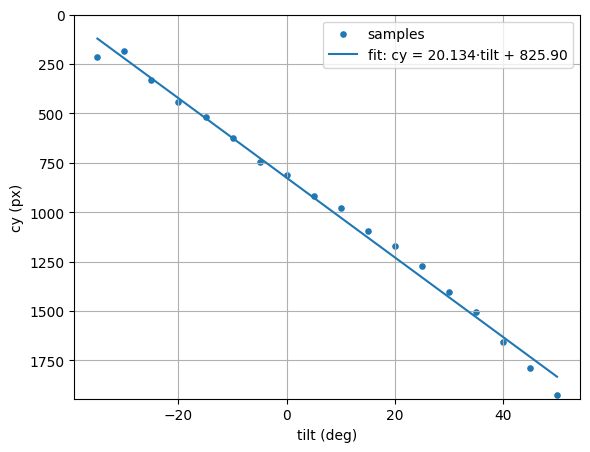

[INFO] gathered rows near pan=90±0.6° : 20
[INFO] dedup per tilt → 18 points
{'pan≈': '90±0.6 deg', 'e_px_per_deg': 20.13379699895995, 'f_px': 825.8966672967546, 'R2': 0.99276906439827, 'max_resid_px': 95.63350244711717, 'N': 18}


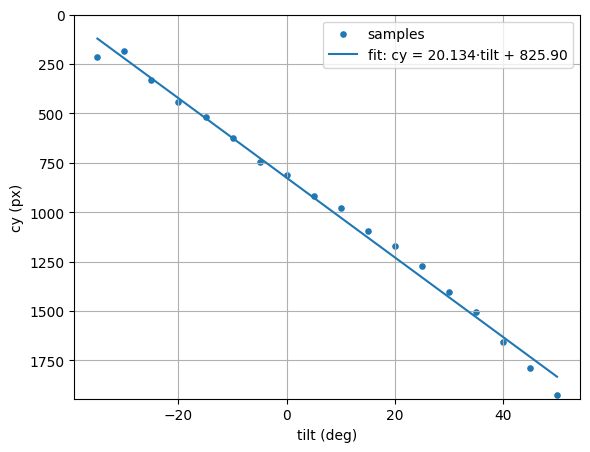

In [182]:
# 모든 tilt 폴더의 CSV를 합쳐서, pan≈PAN_TARGET 인 점들만 모아
# cy vs tilt를 그려보고 선형 피팅(cy ≈ e*tilt + f) 합니다.

import csv, os, numpy as np, matplotlib.pyplot as plt

# --- 폴더/파일 규칙 ---
# 폴더명: yolo_vis_{tilt}   예) yolo_vis_0, yolo_vis_5, ..., yolo_vis_-35
# 파일명: pan_t0_samples.csv (이전과 동일)
tiltlist = [str(i*5) for i in range(0,11)] + ['-'+str(i*5) for i in range(1,8)]
CSV_NAME = "pan_t0_samples.csv"

# --- 분석 파라미터 ---
CONF_MIN    = 0.50         # 신뢰도 필터
USE_CLASS   = None         # 특정 클래스만 보려면 숫자, 전체면 None
PAN_TARGET  = 30.0         # ★ 이 pan 근처만 모을 것 (deg)
PAN_TOL     = 0.6          # pan 허용 오차 (deg) — 너 스캔 스텝이 1°면 0.6~0.7 추천
DEDUP_PER_TILT = True      # 같은 tilt에서 다수 검출이면 conf 최고 1개만 남기기 권장

# --- 데이터 로드 ---
rows = []
W_frame = H_frame = None

list1 = [i for i in range(-20,100,10)]
for i in list1:
    PAN_TARGET = i
    for tilt in tiltlist:
        csv_path = os.path.join(f"yolo_vis_{tilt}", CSV_NAME)
        if not os.path.isfile(csv_path):
            # print(f"[skip] {csv_path} 없음")
            continue
        with open(csv_path, newline="", encoding="utf-8") as f:
            r = csv.DictReader(f)
            for d in r:
                conf = float(d["conf"])
                if conf < CONF_MIN:
                    continue
                cls = int(d["cls"]) if d["cls"]!="" else -1
                if (USE_CLASS is not None) and (cls != USE_CLASS):
                    continue
                pan  = float(d["pan_deg"])
                tilt_deg = float(d["tilt_deg"])
                cx = float(d["cx"]); cy = float(d["cy"])
                if abs(pan - PAN_TARGET) > PAN_TOL:
                    continue
                rows.append({
                    "tilt": tilt_deg, "pan": pan, "cx": cx, "cy": cy,
                    "conf": conf, "cls": cls,
                    "W": int(d["W"]) if d.get("W") else None,
                    "H": int(d["H"]) if d.get("H") else None,
                    "file": d["file"]
                })
                if W_frame is None and d.get("W"): W_frame = int(d["W"])
                if H_frame is None and d.get("H"): H_frame = int(d["H"])

    print(f"[INFO] gathered rows near pan={PAN_TARGET}±{PAN_TOL}° :", len(rows))

    if len(rows) < 3:
        continue
        #raise RuntimeError("샘플이 너무 적습니다. PAN_TARGET/PAN_TOL/CONF_MIN을 조정하세요.")

    # --- 같은 tilt에서 다수면 conf 최고 1개만 남기기(권장) ---
    if DEDUP_PER_TILT:
        best_by_tilt = {}
        for r in rows:
            key = round(r["tilt"], 3)
            if (key not in best_by_tilt) or (r["conf"] > best_by_tilt[key]["conf"]):
                best_by_tilt[key] = r
        rows = list(best_by_tilt.values())
        print(f"[INFO] dedup per tilt → {len(rows)} points")

    # --- 정렬/배열화 ---
    rows.sort(key=lambda x: x["tilt"])
    tilts = np.array([r["tilt"] for r in rows], float)
    cys   = np.array([r["cy"]   for r in rows], float)

    # --- 선형 피팅: cy ≈ e*tilt + f ---
    A = np.vstack([tilts, np.ones_like(tilts)]).T
    e, f = np.linalg.lstsq(A, cys, rcond=None)[0]
    yhat = e*tilts + f
    res  = cys - yhat
    ss_res = float(np.sum(res**2))
    ss_tot = float(np.sum((cys - float(cys.mean()))**2))
    R2 = 1.0 - ss_res/ss_tot if ss_tot>0 else 1.0
    max_resid = float(np.max(np.abs(res)))

    print({
        "pan≈": f"{PAN_TARGET}±{PAN_TOL} deg",
        "e_px_per_deg": float(e),   # tilt 1° 당 cy 픽셀 변화량
        "f_px": float(f),
        "R2": R2,
        "max_resid_px": max_resid,
        "N": len(rows)
    })

    # --- 플롯 (cy vs tilt) ---
    plt.figure(figsize=(6,4.6))
    plt.scatter(tilts, cys, s=14, label="samples")
    xx = np.linspace(min(tilts), max(tilts), 200)
    yy = e*xx + f
    plt.plot(xx, yy, label=f"fit: cy = {e:.3f}·tilt + {f:.2f}")
    plt.xlabel("tilt (deg)")
    plt.ylabel("cy (px)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.gca().invert_yaxis()     # 영상 좌표(y 아래로 +) 감안
    if H_frame:
        plt.ylim(H_frame, 0)
    plt.show()


In [16]:
# --- 설정 ---
CSV_PATH   = r"C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\captures_gui_20250930_021758\scan_20250930_022210_detections.csv"  # 네 CSV 경로
CONF_MIN   = 0.50
USE_CLASS  = None          # 특정 클래스만 쓰려면 정수, 전체면 None
PAN_RANGE  = None          # 예: (-60, 60)만 사용하려면 (min,max)
TILT_RANGE = None          # 예: (-20, 40)
MIN_SAMPLES_PER_FIT = 2    # 최소 샘플 수(30° 스텝이면 2만 돼도 우선 피팅)

import csv, numpy as np
from collections import defaultdict

rows = []
W_frame = H_frame = None

with open(CSV_PATH, newline="", encoding="utf-8") as f:
    r = csv.DictReader(f)
    for d in r:
        if d.get("conf","") == "":
            continue
        conf = float(d["conf"])
        if conf < CONF_MIN:
            continue
        cls = int(d["cls"]) if d["cls"] != "" else -1
        if (USE_CLASS is not None) and (cls != USE_CLASS):
            continue
        pan  = float(d["pan_deg"])  if d.get("pan_deg")  not in ("", None) else None
        tilt = float(d["tilt_deg"]) if d.get("tilt_deg") not in ("", None) else None
        if pan is None or tilt is None:
            continue
        if PAN_RANGE  is not None and not (PAN_RANGE[0]  <= pan  <= PAN_RANGE[1]):  continue
        if TILT_RANGE is not None and not (TILT_RANGE[0] <= tilt <= TILT_RANGE[1]): continue

        cx = float(d["cx"]); cy = float(d["cy"])
        W  = int(d["W"]) if d.get("W") else None
        H  = int(d["H"]) if d.get("H") else None
        if W_frame is None and W: W_frame = W
        if H_frame is None and H: H_frame = H

        rows.append({"pan":pan,"tilt":tilt,"cx":cx,"cy":cy,"conf":conf,"cls":cls})

print(f"[INFO] rows: {len(rows)}, W={W_frame}, H={H_frame}")
assert len(rows) > 0, "유효 행이 없습니다. CSV/필터 확인"


[INFO] rows: 160, W=2592, H=1944


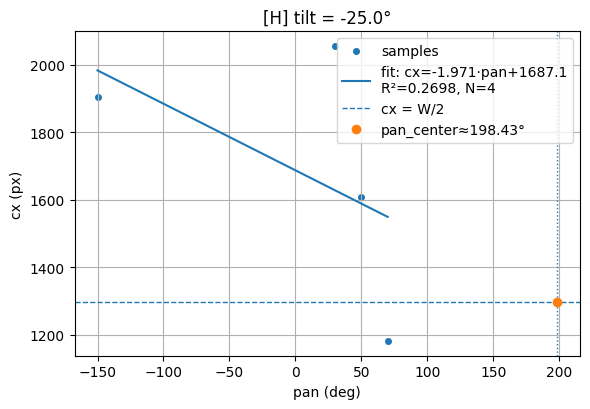

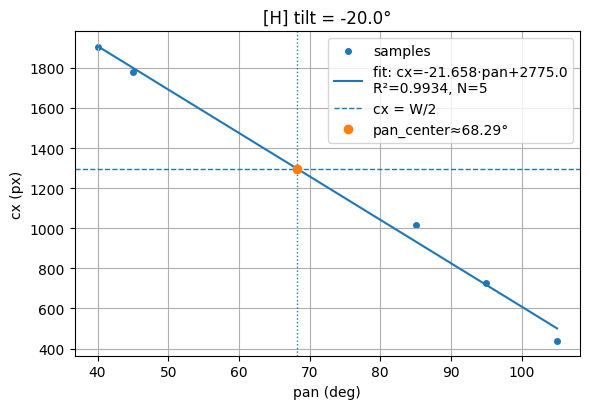

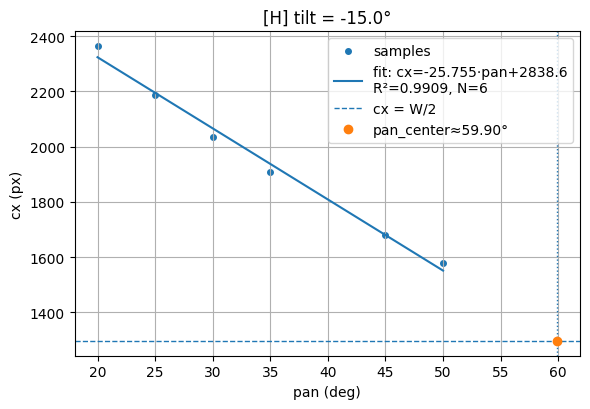

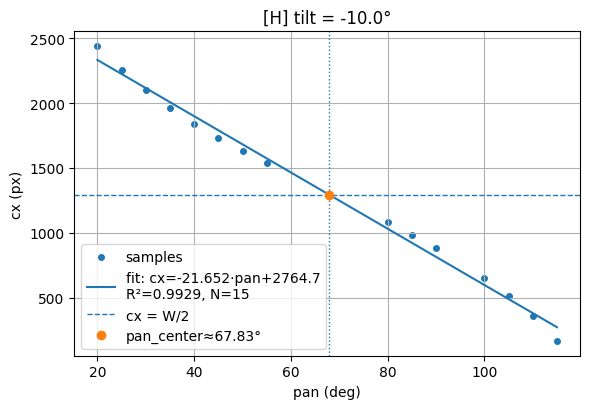

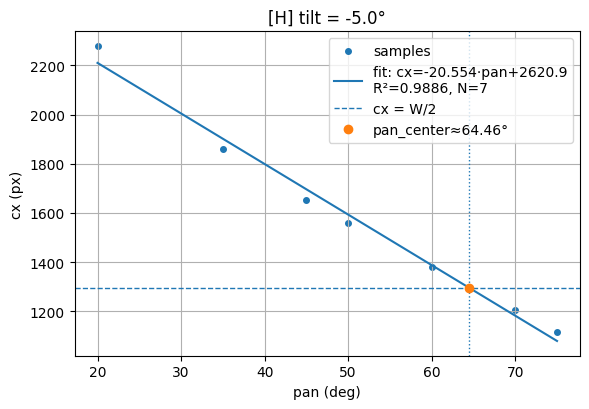

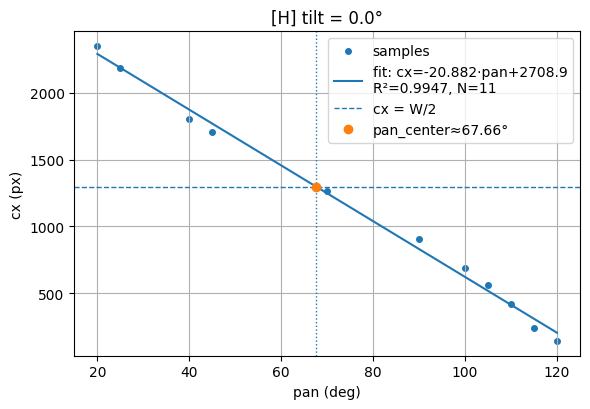

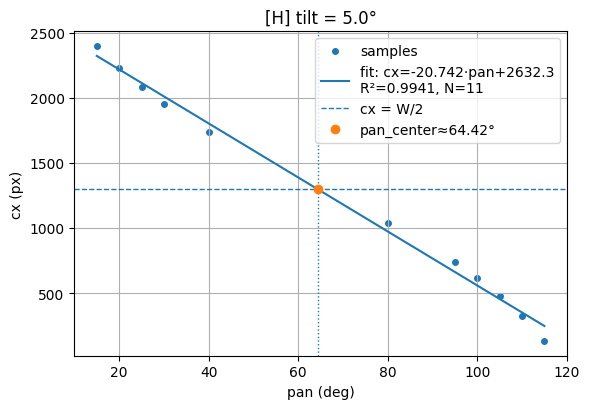

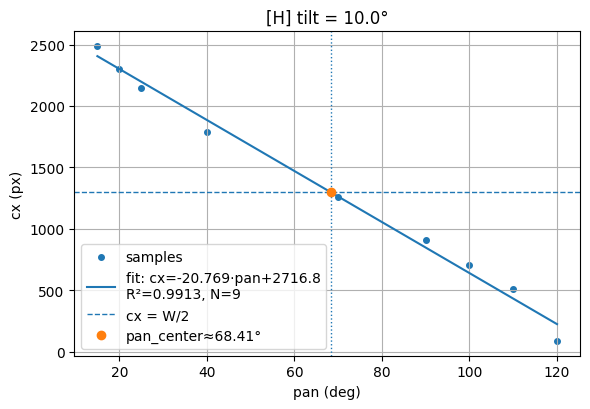

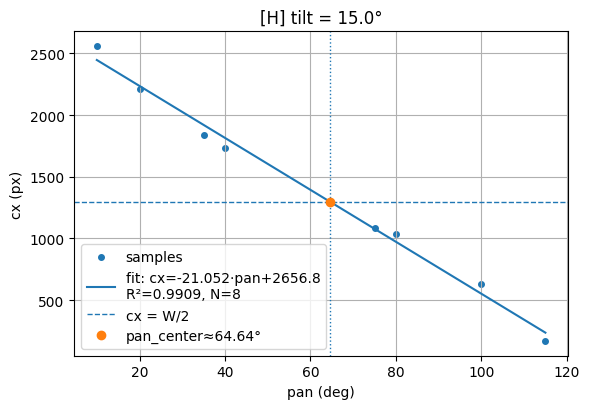

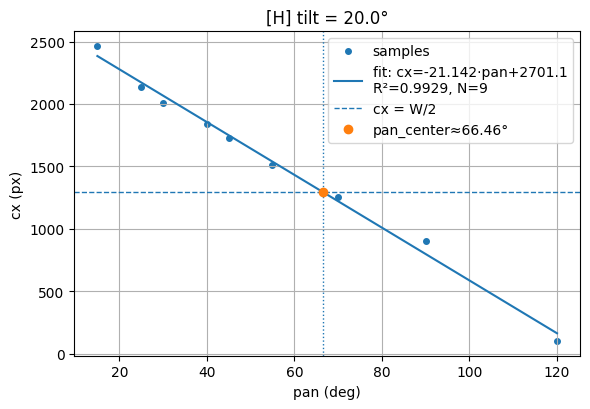

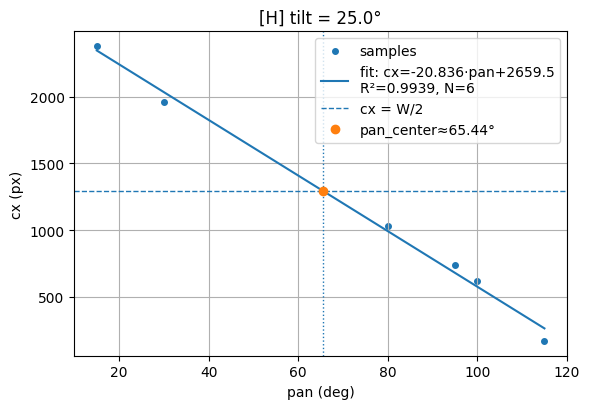

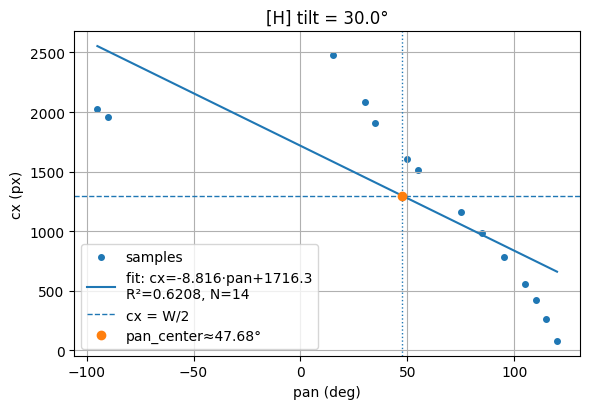

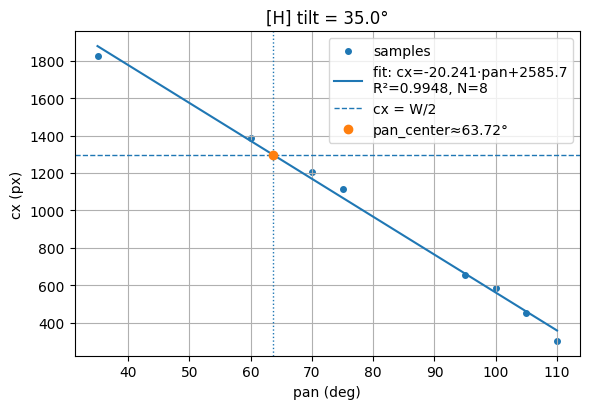

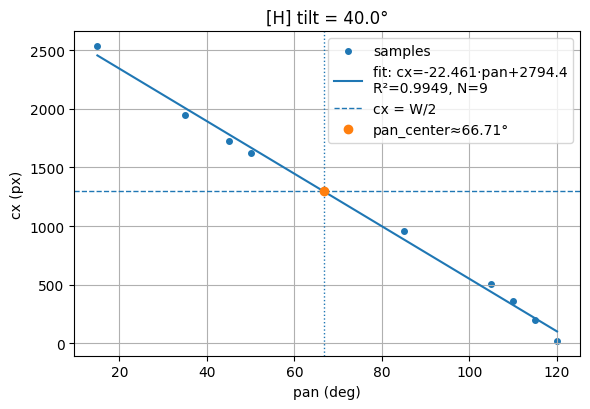

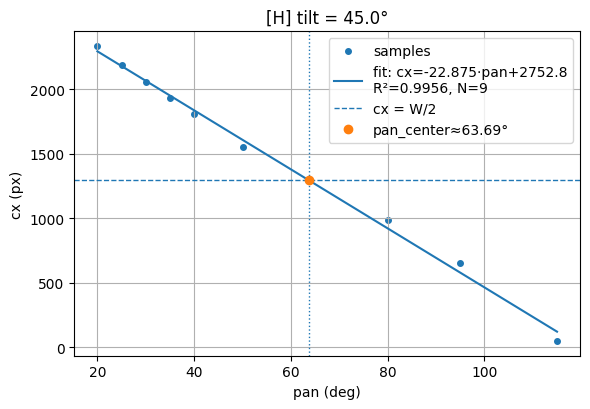

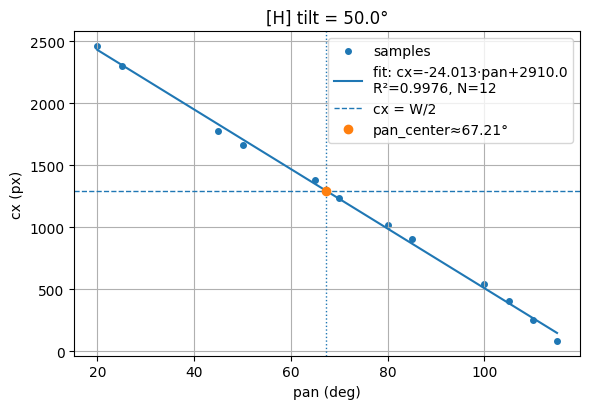

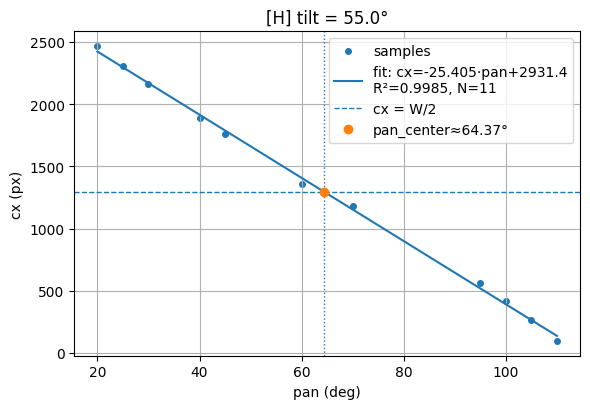

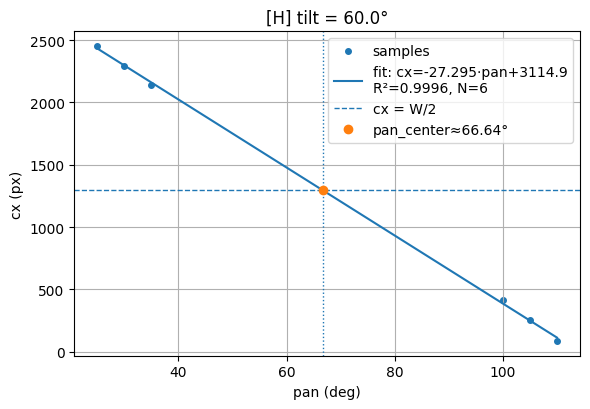

[H] fitted tilts: 18


In [17]:
import numpy as np, matplotlib.pyplot as plt
from collections import defaultdict

def linfit_xy(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    yhat = a*x + b
    resid = y - yhat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y - float(y.mean()))**2))
    R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else 1.0
    return a, b, R2, resid

round_tilt = lambda t: round(t, 3)

# tilt별 그룹 후 피팅
by_tilt = defaultdict(list)
for r in rows:
    by_tilt[ round_tilt(r["tilt"]) ].append(r)

fits_h = {}  # tilt -> dict(a,b,R2,N,pan_center)
for t in sorted(by_tilt.keys()):
    grp = sorted(by_tilt[t], key=lambda r: r["pan"])
    pans = [r["pan"] for r in grp]
    cxs  = [r["cx"]  for r in grp]
    if len(pans) < MIN_SAMPLES_PER_FIT: 
        continue
    a, b, R2, resid = linfit_xy(pans, cxs)
    pan_center = ((W_frame/2.0) - b)/a if a != 0 else np.nan
    fits_h[t] = dict(a=a, b=b, R2=R2, N=len(pans), pan_center=pan_center)

    # 플롯(선택): 각 tilt마다 1장
    plt.figure(figsize=(6,4.2))
    plt.scatter(pans, cxs, s=16, label="samples")
    xx = np.linspace(min(pans), max(pans), 200)
    plt.plot(xx, a*xx + b, label=f"fit: cx={a:.3f}·pan+{b:.1f}\nR²={R2:.4f}, N={len(pans)}")
    plt.axhline(W_frame/2.0, ls="--", lw=1, label="cx = W/2")
    if np.isfinite(pan_center):
        plt.axvline(pan_center, ls=":", lw=1)
        plt.plot([pan_center],[W_frame/2.0],"o", ms=6, label=f"pan_center≈{pan_center:.2f}°")
    plt.title(f"[H] tilt = {t}°")
    plt.xlabel("pan (deg)"); plt.ylabel("cx (px)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

print(f"[H] fitted tilts: {len(fits_h)}")


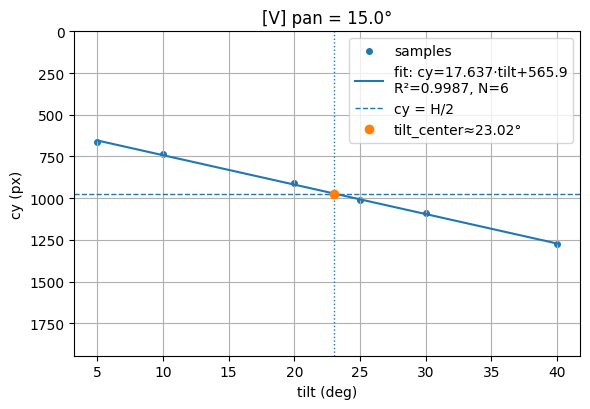

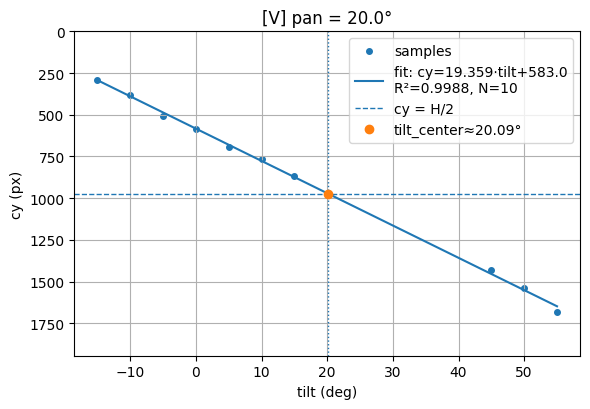

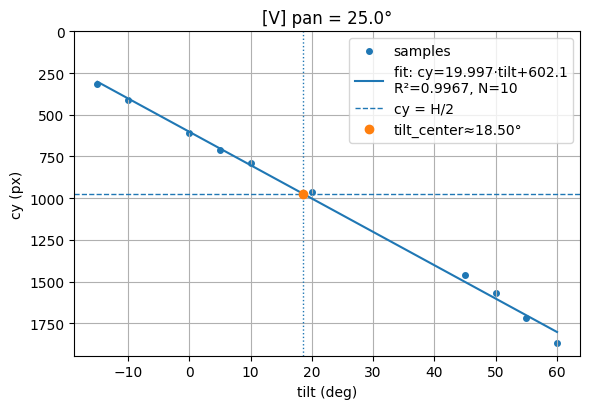

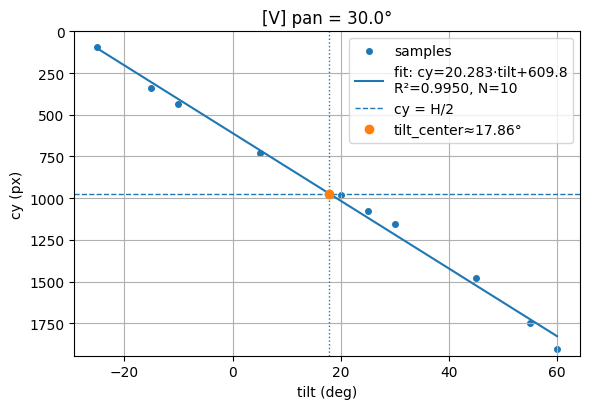

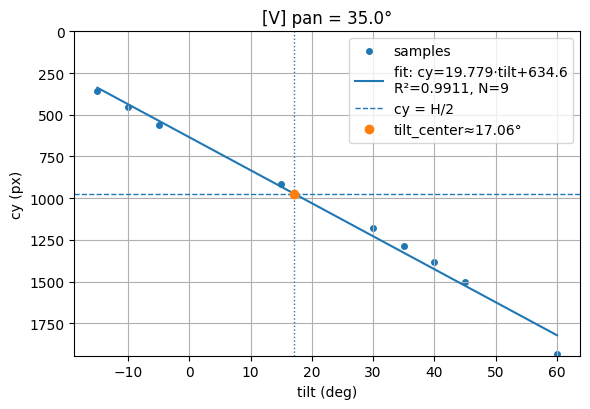

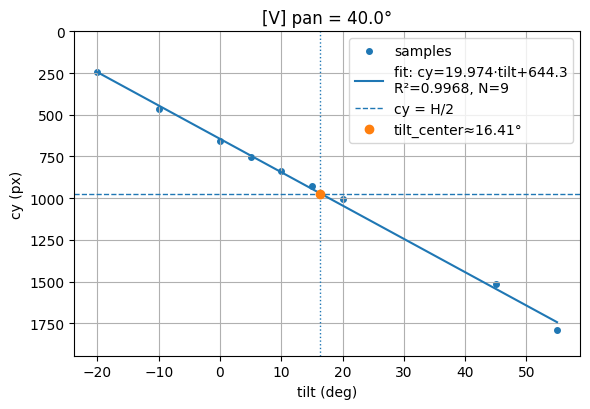

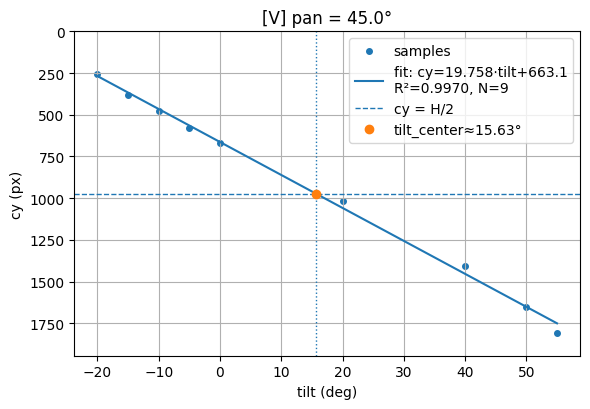

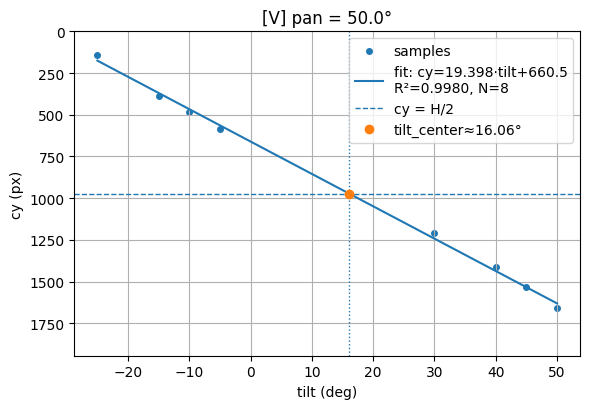

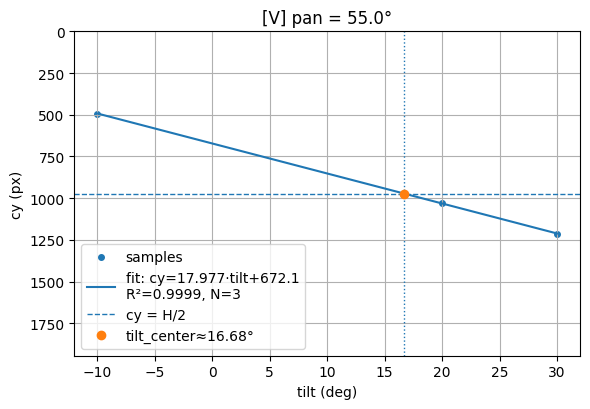

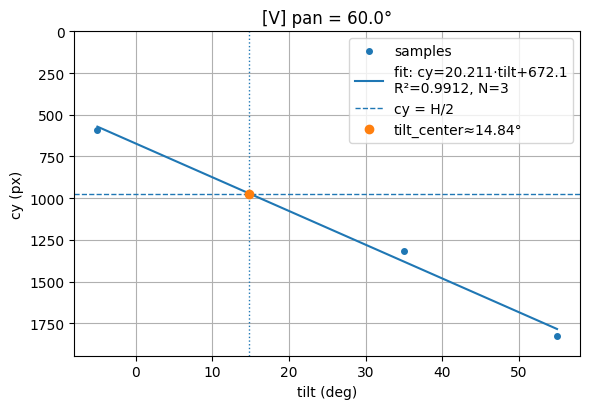

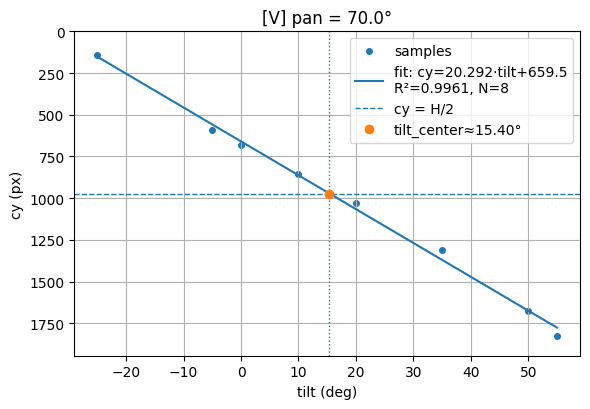

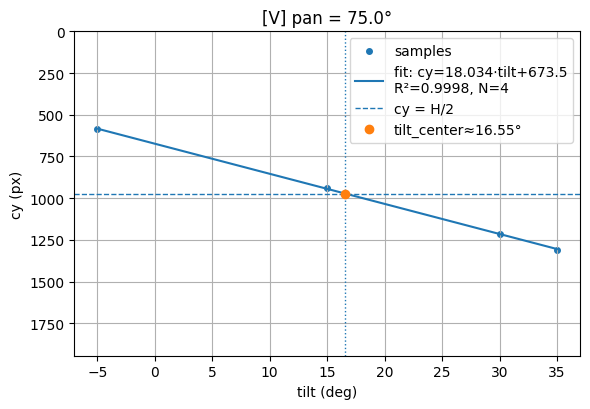

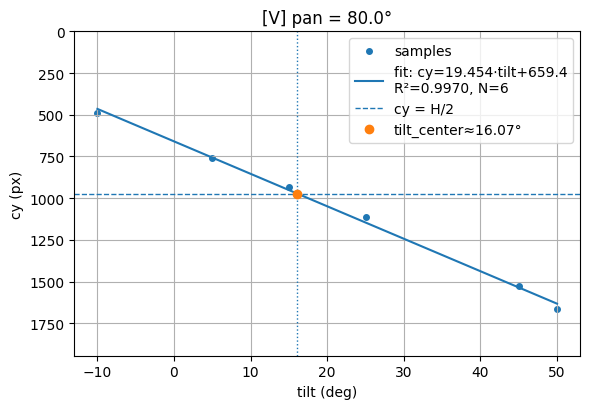

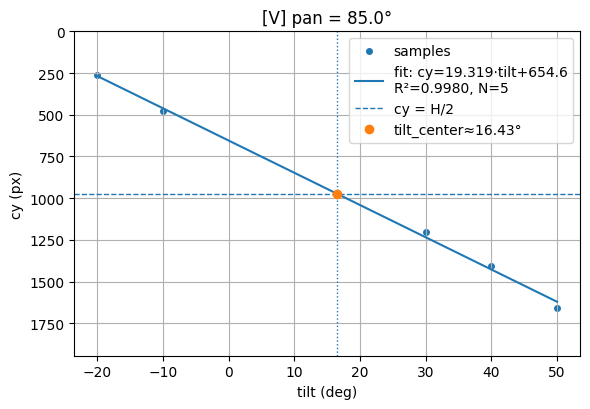

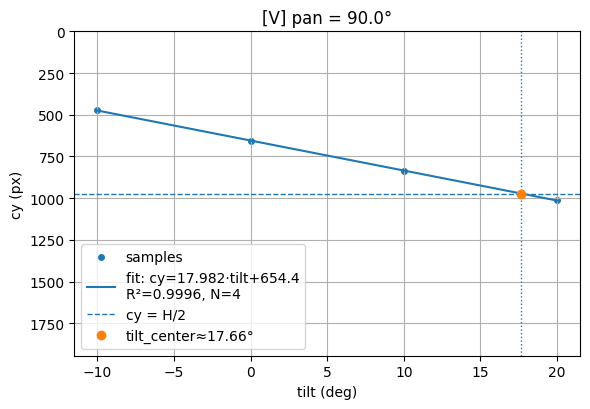

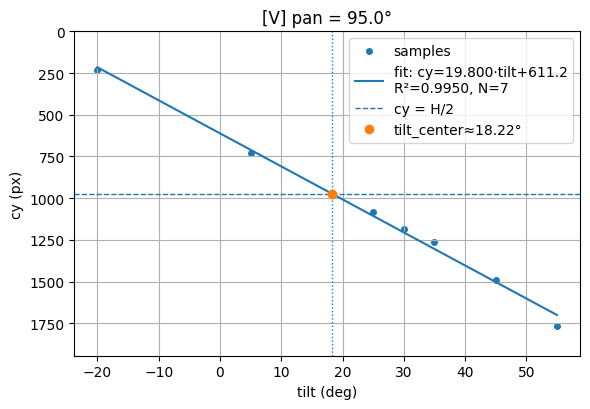

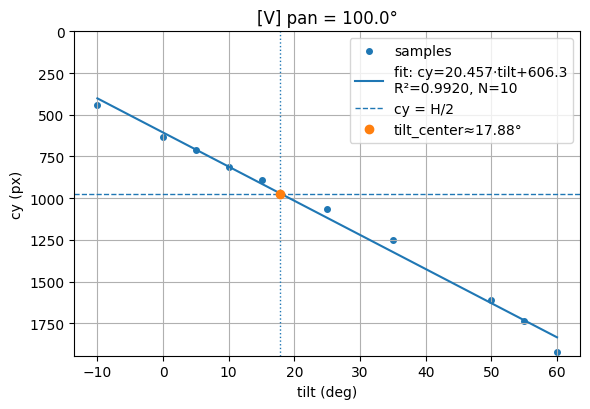

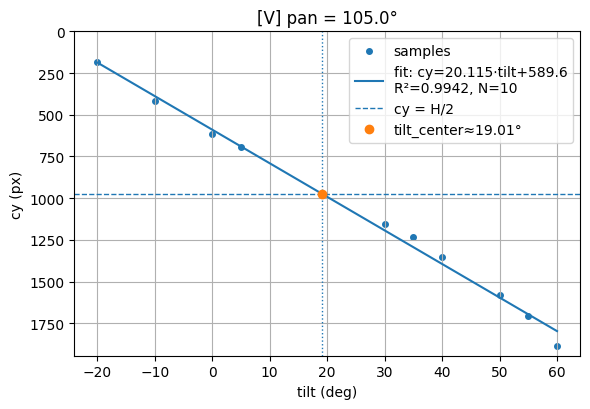

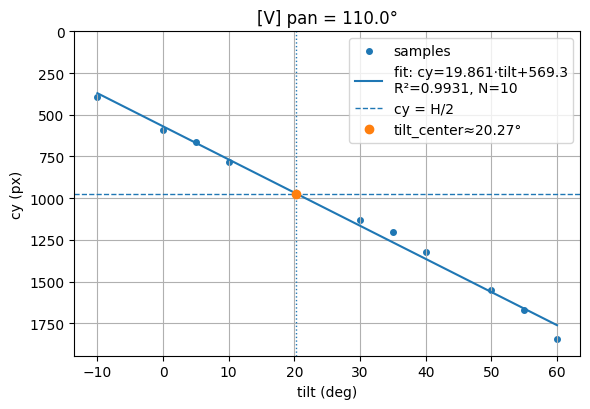

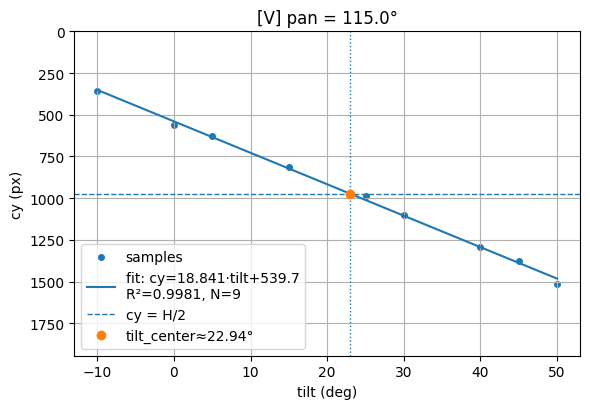

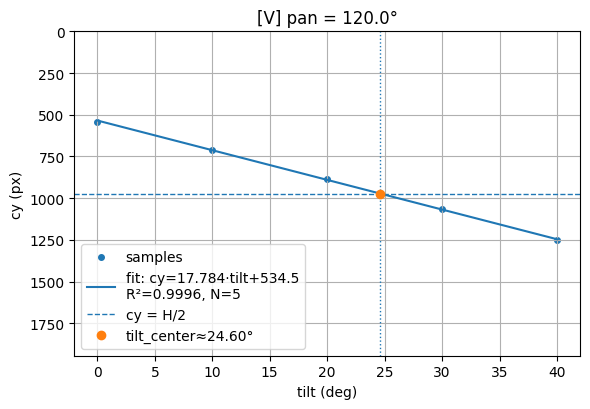

[V] fitted pans: 21


In [18]:
round_pan = lambda p: round(p, 3)

by_pan = defaultdict(list)
for r in rows:
    by_pan[ round_pan(r["pan"]) ].append(r)

fits_v = {}  # pan -> dict(e,f,R2,N,tilt_center)
for p in sorted(by_pan.keys()):
    grp = sorted(by_pan[p], key=lambda r: r["tilt"])
    tilts = [r["tilt"] for r in grp]
    cys   = [r["cy"]   for r in grp]
    if len(tilts) < MIN_SAMPLES_PER_FIT:
        continue
    e, f, R2, resid = linfit_xy(tilts, cys)   # cy = e*tilt + f
    tilt_center = ((H_frame/2.0) - f)/e if e != 0 else np.nan
    fits_v[p] = dict(e=e, f=f, R2=R2, N=len(tilts), tilt_center=tilt_center)

    # 플롯(선택): 각 pan마다 1장
    plt.figure(figsize=(6,4.2))
    plt.scatter(tilts, cys, s=16, label="samples")
    xx = np.linspace(min(tilts), max(tilts), 200)
    plt.plot(xx, e*xx + f, label=f"fit: cy={e:.3f}·tilt+{f:.1f}\nR²={R2:.4f}, N={len(tilts)}")
    plt.axhline(H_frame/2.0, ls="--", lw=1, label="cy = H/2")
    if np.isfinite(tilt_center):
        plt.axvline(tilt_center, ls=":", lw=1)
        plt.plot([tilt_center],[H_frame/2.0],"o", ms=6, label=f"tilt_center≈{tilt_center:.2f}°")
    plt.title(f"[V] pan = {p}°")
    plt.xlabel("tilt (deg)"); plt.ylabel("cy (px)")
    plt.gca().invert_yaxis(); plt.ylim(H_frame, 0)  # 영상 y축 반전
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

print(f"[V] fitted pans: {len(fits_v)}")


In [19]:
import numpy as np
from math import isfinite

def weighted_mean_centers(items, center_key: str, weight_key: str = "N",
                          k: int | None = None, query: float | None = None,
                          window: tuple[float,float] | None = None):
    """
    items: dict[bin_key] -> dict(..., center_key, weight_key)
    center_key: 'pan_center' 또는 'tilt_center'
    weight_key: 기본 'N'
    k: 가까운 k개만 사용하려면 지정 (query 필수)
    query: k-최근접 기준값 (tilt_now 또는 pan_now)
    window: (lo,hi) 범위 내 bin만 사용하려면 지정
    """
    if not items: 
        return np.nan, []

    keys = [float(k) for k in items.keys()
            if isfinite(items[k].get(center_key, np.nan))]
    if not keys: 
        return np.nan, []

    arr_k = np.array(sorted(keys), float)

    # 범위 필터
    if window is not None:
        lo, hi = window
        mask = (arr_k >= lo) & (arr_k <= hi)
        arr_k = arr_k[mask]
        if len(arr_k) == 0:
            return np.nan, []

    # 최근접 k개 선택
    if k is not None:
        assert query is not None, "k-최근접을 쓰려면 query를 지정하세요."
        order = np.argsort(np.abs(arr_k - float(query)))[:max(1, min(k, len(arr_k)))]
        sel = arr_k[order]
    else:
        sel = arr_k

    vals = []
    ws   = []
    used = []
    for key in sel:
        rec = items[key]
        c   = float(rec[center_key])
        w   = float(rec.get(weight_key, 1.0))
        vals.append(c); ws.append(w)
        used.append((float(key), c, int(w)))  # (bin_key, center, N)

    vals = np.array(vals, float)
    ws   = np.array(ws, float)
    target = float(np.sum(vals * ws) / np.sum(ws))
    return target, used

# --- 전역(전체 bin) 가중 평균 ---
pan_target_global, used_h_all   = weighted_mean_centers(fits_h, center_key="pan_center")
tilt_target_global, used_v_all  = weighted_mean_centers(fits_v, center_key="tilt_center")

print(f"[GLOBAL] pan_target = {pan_target_global:.2f}°  (tilt-bins weighted by N)")
print("  used (tilt, pan_center, N):", used_h_all[:6], "..." if len(used_h_all)>6 else "")
print(f"[GLOBAL] tilt_target = {tilt_target_global:.2f}° (pan-bins weighted by N)")
print("  used (pan, tilt_center, N):", used_v_all[:6], "..." if len(used_v_all)>6 else "")




[GLOBAL] pan_target = 67.53°  (tilt-bins weighted by N)
  used (tilt, pan_center, N): [(-25.0, 198.42574251154892, 4), (-20.0, 68.28831025842995, 5), (-15.0, 59.89529754535444, 6), (-10.0, 67.82951974607006, 15), (-5.0, 64.46050386801008, 7), (0.0, 67.65873824084235, 11)] ...
[GLOBAL] tilt_target = 18.29° (pan-bins weighted by N)
  used (pan, tilt_center, N): [(15.0, 23.023899521539036, 6), (20.0, 20.09478440194064, 10), (25.0, 18.4994648352191, 10), (30.0, 17.856481807042165, 10), (35.0, 17.05671362334244, 9), (40.0, 16.406119805365783, 9)] ...


Initial: 680.11px  Final: 3.54px  Reduction: 99.5%
First stable index (<=5px for 4 frames): 59


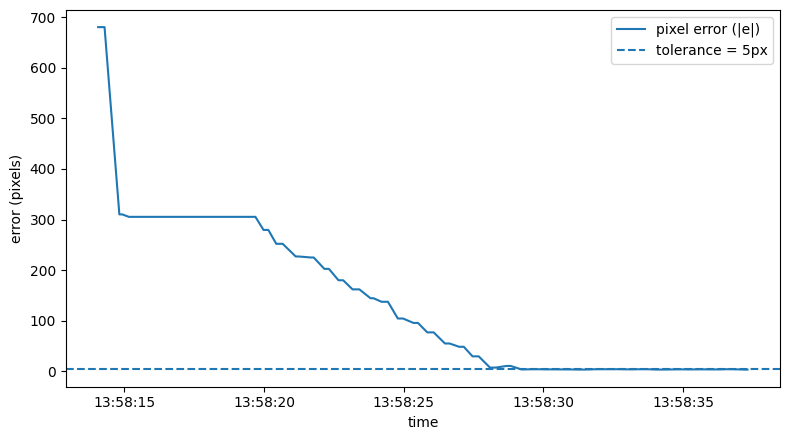

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

csv_path = r"C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\captures_gui_20250930_135428\point_xy_20250930_135812.csv"  

df = pd.read_csv(csv_path)
# 시간축
if "ts" in df.columns:
    try: df["ts"] = pd.to_datetime(df["ts"])
    except: df["ts"] = np.arange(len(df))
else:
    df["ts"] = np.arange(len(df))

# 에러 크기 (픽셀)
ex = df.get("err_x_px", 0).astype(float)
ey = df.get("err_y_px", 0).astype(float)
df["err_px"] = np.sqrt(ex**2 + ey**2)
df["err_px_rolling"] = df["err_px"].rolling(5, min_periods=1).mean()

# 요약
init_err = float(df["err_px"].iloc[0])
final_err = float(df["err_px"].iloc[-1])
print(f"Initial: {init_err:.2f}px  Final: {final_err:.2f}px  Reduction: {(init_err-final_err)/max(init_err,1e-9)*100:.1f}%")

# 안정 구간(옵션)
tol_px, stable_N = 5.0, 4
within = (df["err_px"] <= tol_px).astype(int).values
run = 0; first_stable = -1
for i, ok in enumerate(within):
    run = run + 1 if ok else 0
    if run >= stable_N:
        first_stable = i; break
print("First stable index (<=5px for 4 frames):", first_stable)

# 플롯
x = df["ts"] if np.issubdtype(df["ts"].dtype, np.datetime64) else np.arange(len(df))
plt.figure(figsize=(8,4.5))
plt.plot(x, df["err_px"], label="pixel error (|e|)")
#plt.plot(x, df["err_px_rolling"], label="rolling mean (5)")
plt.axhline(tol_px, linestyle="--", label=f"tolerance = {tol_px:.0f}px")
#plt.title("Pointing pixel error over time")
plt.xlabel("time" if np.issubdtype(df["ts"].dtype, np.datetime64) else "frame index")
plt.ylabel("error (pixels)")
plt.legend()
plt.tight_layout()
plt.show()
